# Projet : Prédiction de la consommation énergétique des appareils électroménagers

Ce notebook a été réalisé dans le cadre du projet de fin de semestre du cours **d’Apprentissage Statistique**. Il vise à mettre en œuvre, sur un cas concret, les notions étudiées pendant le semestre, notamment autour de la régression supervisée.

**Binôme :** Issa KA (<issa.ka@etu.sorbonne-universite.fr>) & Clara Garcia Pérez (<clara.garcia_perez@etu.sorbonne-universite.fr>)  
**Date de rendu :** 30 avril 2025  


# 1. Contexte et objectif

L’objectif de ce projet est de développer un **notebook Python** illustrant :

- La **lecture** et l’**analyse exploratoire** d’un jeu de données réelles ;
- La **mise en place** et la **comparaison** de plusieurs méthodes de régression (linéaire, Ridge, réseau de neurones dense) ;
- La **compréhension** de l’impact des **hyperparamètres** et des **choix de pré‑traitement** sur les performances.

**Données** :  
- Source : UCI ML – Energy Efficiency Data Set  
  https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv  
- Objectif : prédire `Appliances` (Wh) toutes les 10 minutes à partir de mesures ambiantes (températures, humidités, météo, lumière…).


<br>**Référence** :  
> - Candanedo et al., *Data driven prediction models of energy use of appliances in a low-energy house*, *Energy & Buildings* 2017  

In [2]:
# Versions 
import sys
print("Python   :", sys.version.splitlines()[0])
print("Pandas   :", __import__("pandas").__version__)
print("NumPy    :", __import__("numpy").__version__)
print("scikit‑learn:", __import__("sklearn").__version__)
print("Pytorch  :", __import__("torch").__version__)

Python   : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Pandas   : 2.2.2
NumPy    : 1.26.4
scikit‑learn: 1.5.1
Pytorch  : 2.6.0.dev20241108


# 2. Chargement et premier aperçu 

In [3]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils as ut
import importlib
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics         import mean_squared_error, mean_absolute_error, r2_score
importlib.reload(ut)

<module 'utils' from 'c:\\Users\\cheri\\nsi\\M1\\energy_consumption_prediction\\utils.py'>

In [4]:
# Load the dataset
df = pd.read_csv(
    "energydata_complete.csv",
    parse_dates=["date"],     # convert date column to datetime
    index_col="date"          # set date as index
)

In [5]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [6]:
print("Informations sur le DataFrame :\n")
df.info()

Informations sur le DataFrame :

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 n

In [7]:
print(f"Dimensions : {df.shape[0]} lignes et {df.shape[1]} colonnes")

Dimensions : 19735 lignes et 28 colonnes


**Premier aperçu** :
- **Granularité temporelle** : 10 minutes.  
- **Période couverte** : ~137 jours donc 4 mois (janvier–mai 2016).  
- **Nombre d’observations** : 19 735 
- **valeurs manquantes** : 0
- **Nombre de variables** :  
  - 1 cible : `Appliances` (Wh)  
  - 1 variable temporelle : `date` (timestamp)
  - 27 variables explicatives (temperatures, humidités, météo…)  

# 3. Analyse descriptive

Avant toute analyse, on commence par **supprimer** les deux variables aléatoires créées pour le filtrage (`rv1`, `rv2`), qui n’apportent rien à l’exploration.

In [8]:
# Delete the columns 'rv1' and 'rv2' as they are not needed for the analysis
df = df.drop(columns=['rv1', 'rv2'])

In [9]:
# new shape after dropping columns
df.shape

(19735, 26)

On a maintenant 25 **variables explicatives** 

**Description des variables** :

| Variable       | Description                                                      | Unité   |
|----------------|------------------------------------------------------------------|---------|
| **date**       | Date et heure (AAAA‑MM‑JJ HH:MM:SS)                              | –       |
| **Appliances** | Consommation énergétique des appareils ménagers                  | Wh      |
| **lights**     | Consommation énergétique de l’éclairage                          | Wh      |
| **T1**         | Température dans la cuisine                                      | °C      |
| **RH_1**       | Humidité relative dans la cuisine                                | %       |
| **T2**         | Température dans le salon                                        | °C      |
| **RH_2**       | Humidité relative dans le salon                                  | %       |
| **T3**         | Température dans la buanderie                                    | °C      |
| **RH_3**       | Humidité relative dans la buanderie                              | %       |
| **T4**         | Température dans le bureau                                       | °C      |
| **RH_4**       | Humidité relative dans le bureau                                 | %       |
| **T5**         | Température dans la salle de bain                                | °C      |
| **RH_5**       | Humidité relative dans la salle de bain                          | %       |
| **T6**         | Température extérieure (côté nord du bâtiment)                   | °C      |
| **RH_6**       | Humidité relative extérieure (côté nord du bâtiment)             | %       |
| **T7**         | Température dans la pièce de repassage                           | °C      |
| **RH_7**       | Humidité relative dans la pièce de repassage                     | %       |
| **T8**         | Température dans la chambre adolescente 2                         | °C      |
| **RH_8**       | Humidité relative dans la chambre adolescente 2                   | %       |
| **T9**         | Température dans la chambre des parents                          | °C      |
| **RH_9**       | Humidité relative dans la chambre des parents                    | %       |
| **T_out**      | Température extérieure (aéroport à proximité)                    | °C      |
| **Press_mm_hg**| Pression atmosphérique                                           | mm Hg   |
| **RH_out**     | Humidité relative extérieure                                     | %       |
| **Windspeed**  | Vitesse du vent                                                  | m/s     |
| **Visibility** | Visibilité                                                       | km      |
| **Tdewpoint**  | Température du point de rosée                                    | °C      |

## 3.1 Statistiques descriptives globales

In [10]:
stats = df.describe().T.round(2) # Transpose the summary and round the values to 2 decimal places
stats

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.0,97.69,102.52,10.00,50.00,60.00,100.00,1080.00
lights,19735.0,3.80,7.94,0.00,0.00,0.00,0.00,70.00
T1,19735.0,21.69,1.61,16.79,20.76,21.60,22.60,26.26
RH_1,19735.0,40.26,3.98,27.02,37.33,39.66,43.07,63.36
T2,19735.0,20.34,2.19,16.10,18.79,20.00,21.50,29.86
RH_2,19735.0,40.42,4.07,20.46,37.90,40.50,43.26,56.03
T3,19735.0,22.27,2.01,17.20,20.79,22.10,23.29,29.24
RH_3,19735.0,39.24,3.25,28.77,36.90,38.53,41.76,50.16
T4,19735.0,20.86,2.04,15.10,19.53,20.67,22.10,26.20
RH_4,19735.0,39.03,4.34,27.66,35.53,38.40,42.16,51.09


**Interprétation des statistiques globales**
1. **Variable cible `Appliances`**  
   - **Moyenne** ≃ 98 Wh, **écart‑type** ≃ 102 Wh : forte dispersion, signe d’alternance entre périodes calmes et pointes de consommation.  
   - **Minimum** à 10 Wh, **maximum** à 1080 Wh : présence de valeurs extrêmes (pics de consommation) qui pourraient influencer la modélisation.

2. **Éclairage `lights`**  
   - Moyenne faible (≈ 3.8 Wh), très souvent nulle (**médiane** 0, **75 %** des observations à 0) avec quelques pointes jusqu’à 70 Wh : usage occasionnel, potentiellement indicateur d’occupation.

3. **Températures intérieures (`T1` à `T5`, `T7` à `T9`)**  
   - Globalement comprises entre 15 et 30 °C, **moyennes** entre 19 et 22 °C, avec une faible variabilité (écart‑type ≃ 1.5 à 2.5 °C).  
   - Indique un bon niveau d’isolation et un contrôle thermique efficace à l’intérieur.

4. **Humidité relative intérieure (`RH_1` à `RH_5`, `RH_7` à `RH_9`)**  
   - Moyennes généralement entre 35 % et 50 %, sauf en salle de bain (`RH_5`) où l’humidité peut monter à 96 %.  
   - Des pics d’humidité dans certaines pièces peuvent signaler l’usage intensif de douches, machines ou autres appareils électroménager.

5. **Indicateurs extérieurs**  
   - **T6** (température nord du bâtiment) : moyenne ≃ 7.9 °C, varie de −6 °C à +28 °C ; **RH_6** : moyenne ≃ 54.6 %, de 1 % à 99.9 %.  
   - **T_out** (météo aéroport) : moyenne ≃ 7.4 °C, de −5 °C à +26 °C.  
   - Vent modéré (moyenne ≃ 4 m/s, max 14 m/s), visibilité majoritairement élevée (> 40 km), pression stable autour de 755 mm Hg.

> Ces premières statistiques révèlent une **forte hétérogénéité** de la consommation `Appliances`, des **conditions intérieures relativement stables** et des **indicateurs extérieurs** plus variables. Nous allons poursuivre ces analyse pour prendre en compte ces éléments dans la modélisation.

## 3.2 Analyse de la cible `Appliances`

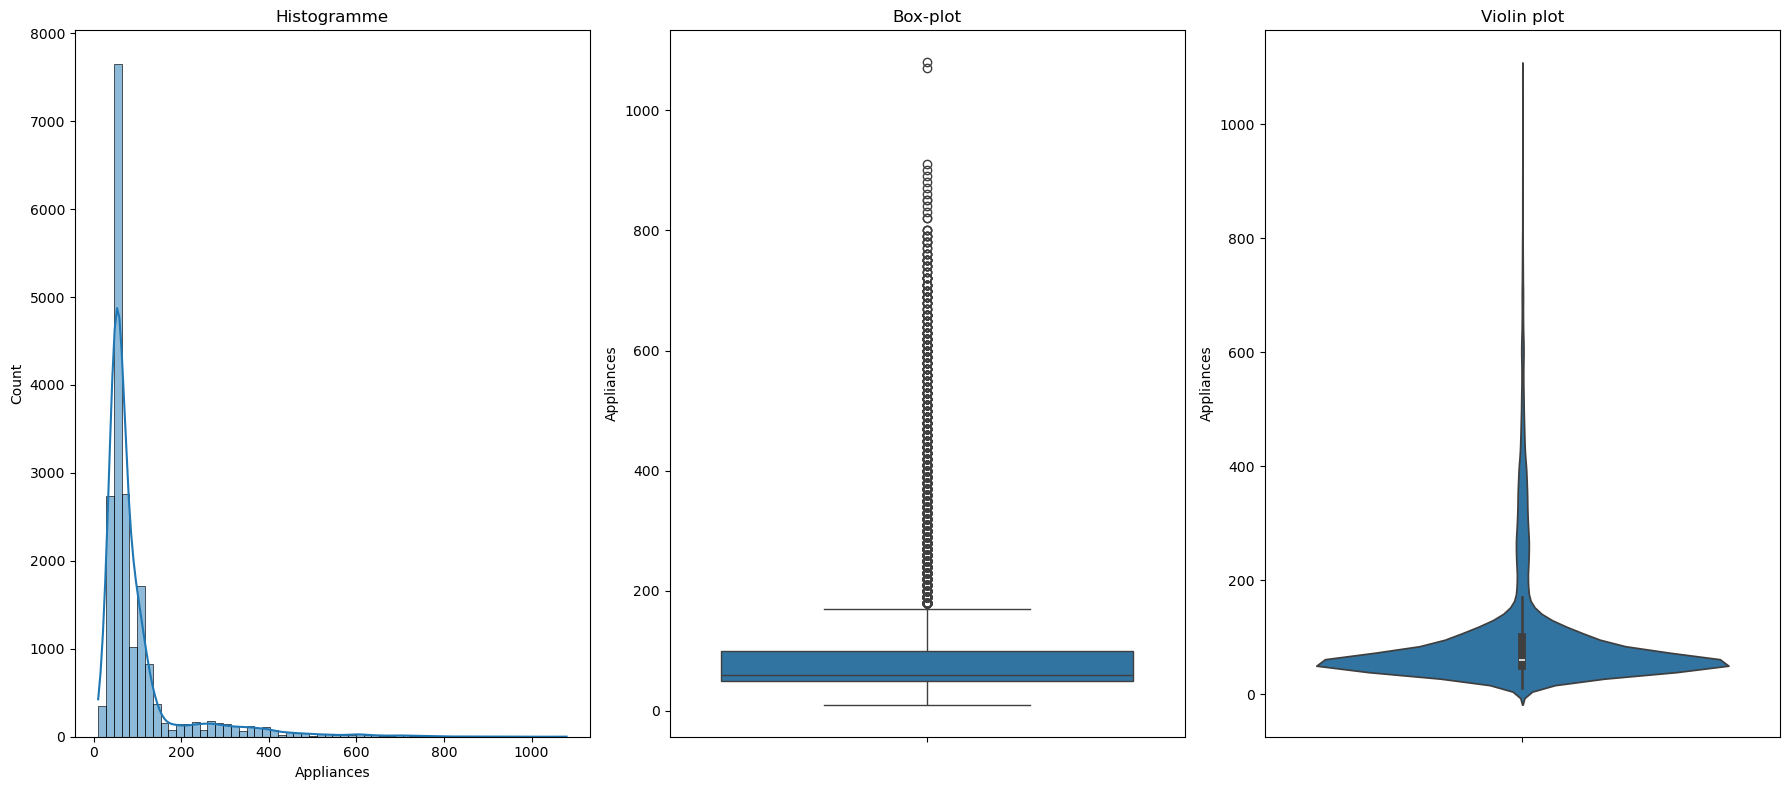

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Histogram
sns.histplot(df['Appliances'], bins=60, kde=True, ax=axes[0])
axes[0].set_title("Histogramme")

# Boxplot
sns.boxplot(y=df['Appliances'], ax=axes[1])
axes[1].set_title("Box‑plot")

# Violin plot
sns.violinplot(y=df['Appliances'], ax=axes[2])
axes[2].set_title("Violin plot")

plt.tight_layout()
plt.show()


Cela confirme et précise les conclusions précédentes sur la consommation `Appliances` :
- **Distribution très asymétrique**  
  - La majorité des valeurs se concentre entre 10 Wh et 150 Wh (histogramme), avec une longue queue à droite jusqu’à ≃ 1 080 Wh.  
  - La **médiane** (~ 60 Wh) est inférieure à la **moyenne** (~ 98 Wh) : les rares pointes élevées tirent la moyenne vers le haut.

- **Outliers marqués**  
  - Le box‑plot montre de nombreux points au‑dessus du 75ᵉ quantile (~ 100 Wh) et des valeurs extrêmes autour de 800–1 000 Wh.  
  - Ces pointes peuvent correspondre à des appareils gros consommateurs (lave‑linge, four), des périodes de forte occupation ou des erreurs de mesure.


On créé des variables catégorielles temporelles pour mieux comprendre la consommation `Appliances` :
- `dayofweek` : jour de la semaine (0 = lundi, 6 = dimanche)
- `hour` : heure de la journée (0–23)

On envisage aussi de les utiliser comme variables explicatives dans la modélisation. 

In [12]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek  # 0 = lundi…6 = dimanche


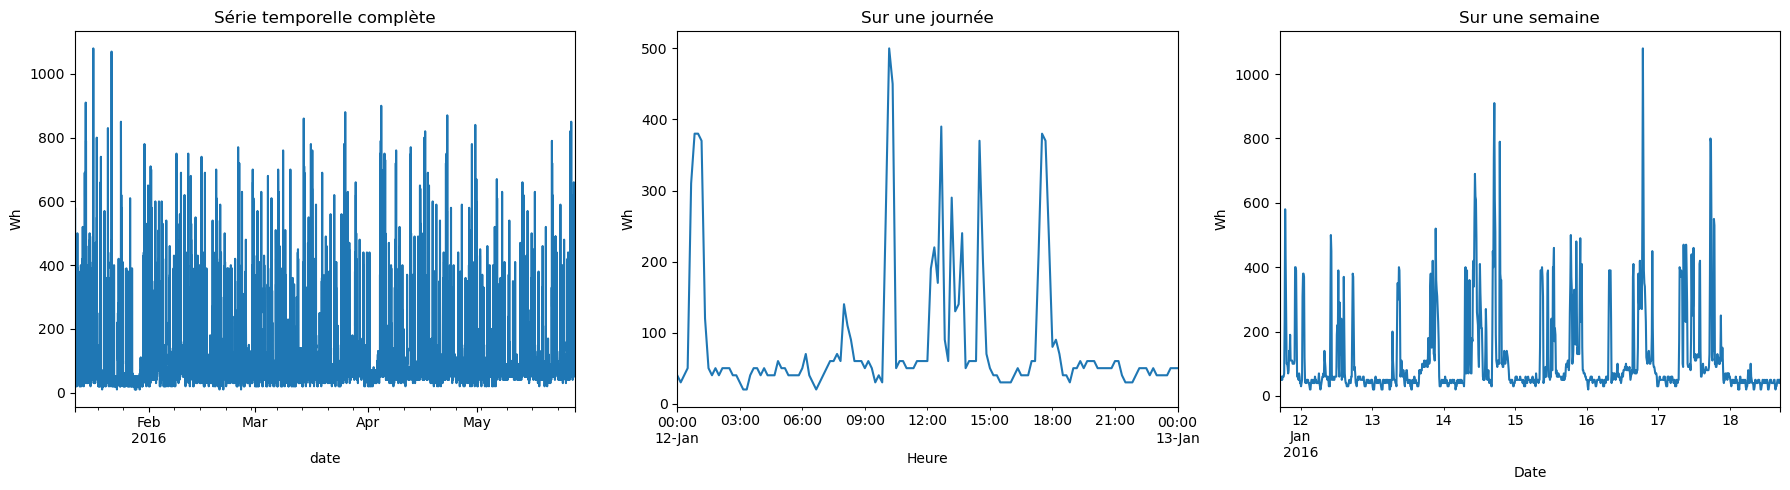

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# time series on the complete dataset
df['Appliances'].plot(ax=axes[0])
axes[0].set_title("Série temporelle complète")
axes[0].set_ylabel("Wh")

# time series on a day (first day of the dataset)
jour = df.loc[df.index[0]+ pd.Timedelta(hours=7):df.index[0] + pd.Timedelta(hours=7) + pd.Timedelta(days=1)] # because the first day starts at 17h
jour['Appliances'].plot(ax=axes[1])
axes[1].set_title("Sur une journée")
axes[1].set_xlabel("Heure")
axes[1].set_ylabel("Wh")

# time series on a week (first week of the dataset)
premiere_semaine = df.loc[(df.index >= df.index[0]) & (df.index < df.index[0] + pd.Timedelta(days=7))]
premiere_semaine['Appliances'].plot(ax=axes[2])
axes[2].set_title("Sur une semaine")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Wh")

plt.tight_layout()
plt.show()

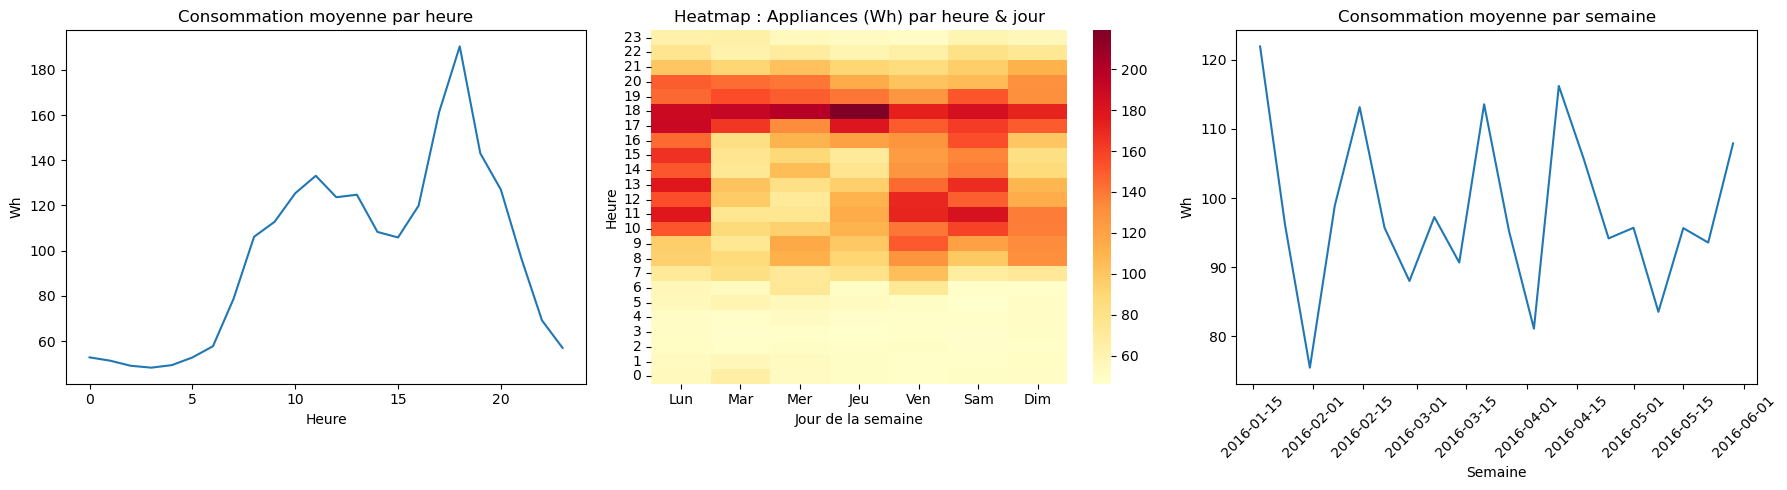

In [14]:
hourly = df.groupby('hour')['Appliances'].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# average consumption per hour
sns.lineplot(x=hourly.index, y=hourly.values, ax=axes[0])
axes[0].set_title("Consommation moyenne par heure")
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Wh")

# heatpmap : Appliances (Wh) by hour & day of the week
pivot = df.pivot_table(index='hour', columns='dayofweek', values='Appliances', aggfunc='mean')
sns.heatmap(pivot.iloc[::-1], cmap='YlOrRd', annot=False,
            yticklabels=range(23, -1, -1), 
            xticklabels=['Lun','Mar','Mer','Jeu','Ven','Sam','Dim'], ax=axes[1])
axes[1].set_title("Heatmap : Appliances (Wh) par heure & jour")
axes[1].set_xlabel("Jour de la semaine")
axes[1].set_ylabel("Heure")

# average consumption per week
weekly = df.resample('W').Appliances.mean()
sns.lineplot(x=weekly.index, y=weekly.values, ax=axes[2])
axes[2].set_title("Consommation moyenne par semaine")
axes[2].set_xlabel("Semaine")
axes[2].set_ylabel("Wh")
for label in axes[2].get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

- **Comportements temporels réguliers**  
  - Les graphiques montrent une **consommation faible** la nuit, qui augmente le matin et atteint un **pic** à l’heure des repas (12h–14h) et en soirée (18h–20h).
  - Cela reflète un **usage domestique typique** : faible consommation la nuit, hausse lors des activités matinales, pic à l'heure des repas et en soirée.
  - La **volatilité** de la série temporelle complète confirme l’alternance entre périodes calmes et pics de consommation.
  - La **heatmap** révèle que ces pics sont présents tous les jours (surtout de 18 à 20h) mais pas de comportement très différent le **week-end**.
  - Il n’y a pas de **saisonnalité mensuelle** visible, car les données couvrent seulement 4 mois (janvier à mai) où la consommation reste relativement stable d’une semaine à l’autre.
  - La **variabilité intra-journalière** est bien plus forte que la variabilité entre jours de la semaine : l’**heure** est donc un facteur déterminant pour prédire la consommation.
  - la courbe **hebdomadaire** montre des fluctuations notables d’une semaine à l’autre autours d'une moyenne à 100Wh, traduisant une variabilité inter‑semaine non négligeable.  

> **Implications pour la modélisation**  
> - La **forte asymétrie** (skewness) et la présence d’**outliers** dans la distribution de `Appliances` suggèrent de tester une transformation (par exemple `log(Appliances)`) ou d’utiliser des modèles robustes (comme Lasso).  
> - Un **lissage** ou un **filtrage** des valeurs extrêmes pourrait améliorer la stabilité et la performance des modèles prédictifs.  
> - Les **pics récurrents** et la forte variabilité intra-journalière confirment l’intérêt de créer des **features temporelles** (`hour`, `dayofweek`) et éventuellement des lags pour capturer les cycles d’usage.  
> - La **heatmap** nous encourage à créer des **indicateurs** du type jour vs nuit
> - Une **moyenne mobile** pourrait être utile pour lisser les variations inter‑semaine et mieux capturer les tendances sous-jacentes.

## 3.3 Corrélations & relations entre variables

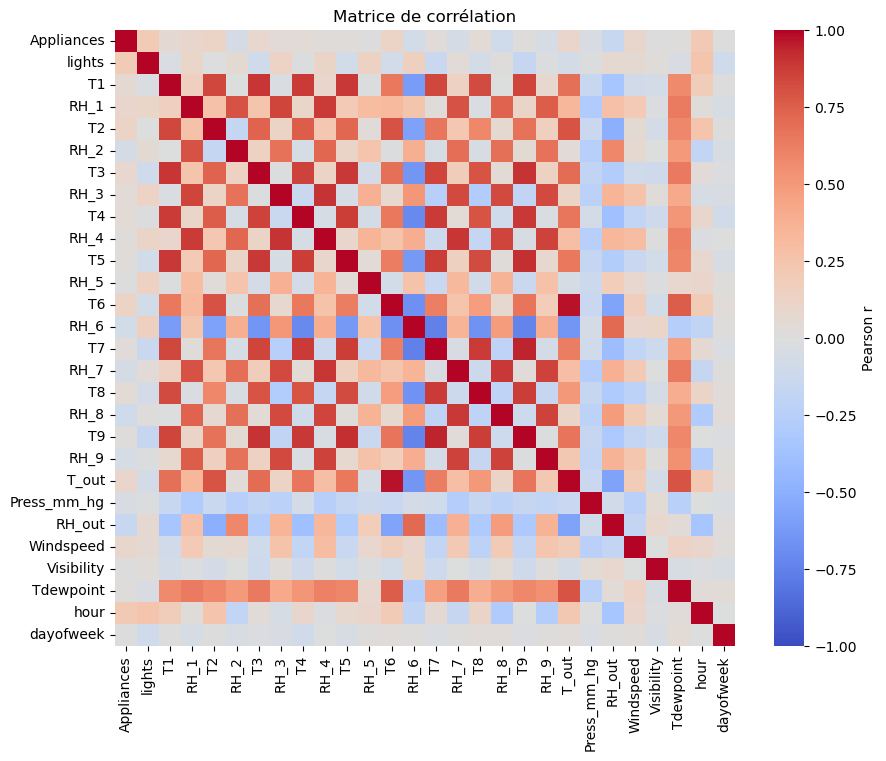

In [15]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            cbar_kws={'label':'Pearson r'})
plt.title("Matrice de corrélation")
plt.show()

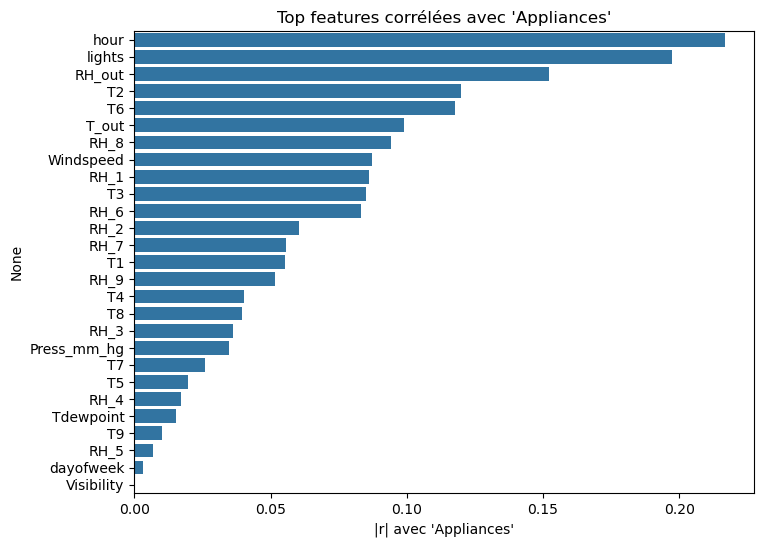

In [16]:
corr_target = df.corr()['Appliances'].abs().sort_values(ascending=False)[1:]
top_feats = corr_target.index

plt.figure(figsize=(8,6))
sns.barplot(y=top_feats, x=corr_target.values, orient='h')
plt.xlabel("|r| avec 'Appliances'")
plt.title("Top features corrélées avec 'Appliances'")
plt.show()

- Toutes les températures et humidités sont évidement extrêmement **corrélées** entre elles, il va donc falloir gérer cette **multicolinéarité** dans la modélisation.
- On remarque globalement peu de correlation avec la cible `Appliances`
- En revanche, `hour` est le facteur le plus corrélé avec `Appliances` (~22%) ce qui confirme l’importance de l’heure dans la consommation d’énergie.
- Aussi, `lights` et la température dans le salon `T2` ont une correlation de ~20% et 15% avec `Appliances`. Ils représentent de bons **indicateurs d'occupation** et donc de consommation d'énergie.
- l'humidité extérieur `RH_out` et les températures extérieurs `T_out` et `T6` sont aussi corrélée avec la cible (~15, ~12 et ~10% respectivement). 


> Pistes pour le feature engineering :  
>  - **ACP** ou **moyennes** pour réduire la multicolinéarité des variables de température et d’humidité.
>  - Créer un **indicateur d'occupation** à partir de `lights` et `T2`.

# 4. Feature engineering

On a déjà ajouté quelques features temporelles (`hour`, `dayofweek`), on va maintenant créer d’autres features et on analysera leur impact sur les performances des modèles.

### 4.1 Indicateur d'occupation

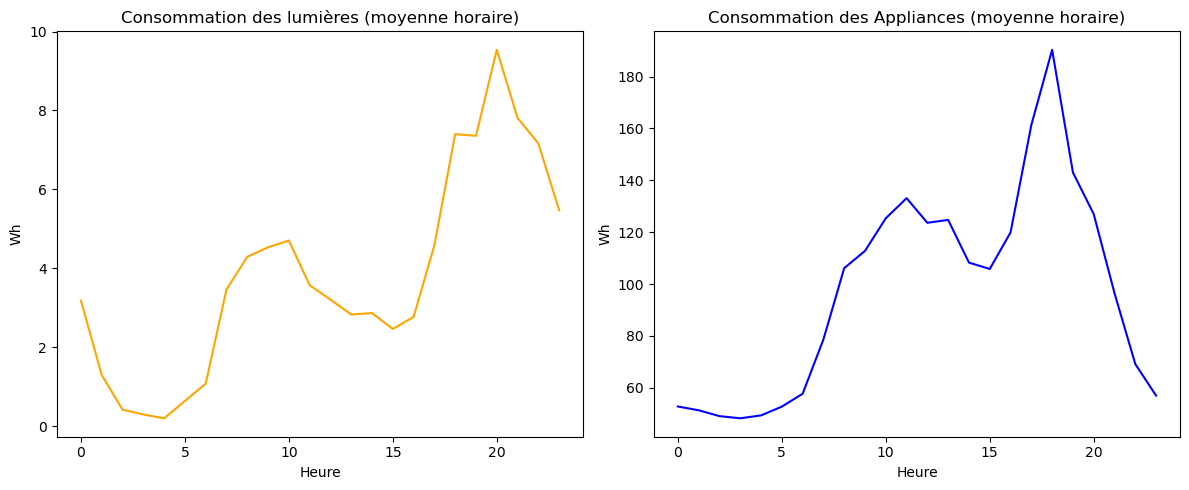

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Average occupancy by hour
df.groupby('hour')['lights'].mean().plot(ax=axes[0], color='orange')
axes[0].set_title("Consommation des lumières (moyenne horaire)")
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Wh")

# Average appliances by hour
df.groupby('hour')['Appliances'].mean().plot(ax=axes[1], color='blue')
axes[1].set_title("Consommation des Appliances (moyenne horaire)")
axes[1].set_xlabel("Heure")
axes[1].set_ylabel("Wh")

plt.tight_layout()
plt.show()


Le graphique horaire des consommations de `lights` (orange) et `Appliances` (bleu) révèle des profils presque identiques. 

Cela suggère que l’allumage des lumières est un excellent **proxy** de la présence d’occupants.

On va donc créer un indicateur binaire `occupancy` qui sera égal à 1 si `lights` > 0 et 0 sinon.

In [18]:
df['occupancy'] = (df['lights'] > 0).astype(int)

On dispose maintenant de deux régimes :
- **occupancy = 0** : pas de lumière allumée (probablement pas d’occupants ou endormis la nuit donc inactifs)  
- **occupancy = 1** : lumière allumée (présence d’occupants actifs)

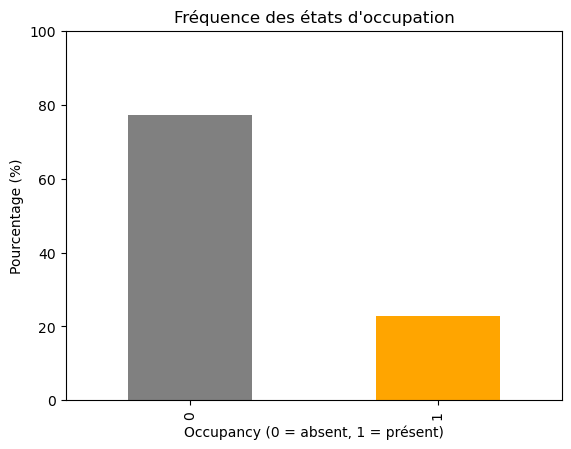

Répartition d'occupancy (en % des intervalles) :
occupancy
0    77.3%
1    22.7%
Name: proportion, dtype: object


In [19]:
# Frequency of occupancy
freq = df['occupancy'].value_counts(normalize=True).mul(100).round(1)

freq.plot(kind='bar', color=['gray', 'orange'])
plt.title("Fréquence des états d'occupation")
plt.xlabel("Occupancy (0 = absent, 1 = présent)")
plt.ylabel("Pourcentage (%)")
plt.ylim(0, 100)
plt.show()

print("Répartition d'occupancy (en % des intervalles) :")
print(freq.astype(str) + '%')

On constate que **occupancy = 1** n’apparaît que dans **20 %** des intervalles :  
- Assez fréquent pour être stabilisé en apprentissage  
- Assez rare pour segmenter nettement deux comportements de consommation

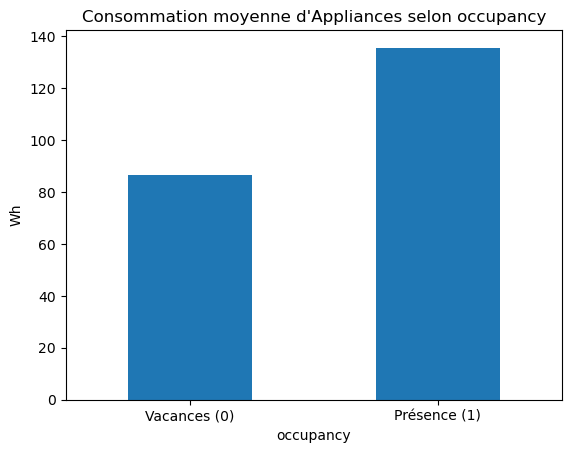


Consommation moyenne d'Appliances (Wh) :
occupancy
0     86.6
1    135.5
Name: Appliances, dtype: float64


In [20]:
mean_by_occ = df.groupby('occupancy')['Appliances'].mean().round(1)

mean_by_occ.plot(kind='bar')
plt.xticks([0,1], ['Vacances (0)', 'Présence (1)'], rotation=0)
plt.ylabel("Wh")
plt.title("Consommation moyenne d'Appliances selon occupancy")
plt.show()

print("\nConsommation moyenne d'Appliances (Wh) :")
print(mean_by_occ)

La différence est massive :
- **≈ 86 Wh** quand `occupancy = 0`  
- **≈ 135 Wh** quand `occupancy = 1`  

Cette dichotomie capture d’un seul coup une part importante de la variance de la cible, justifiant pleinement l’ajout de l’indicateur `occupancy`.

> **Conclusion :**
>  
> L’ajout de l’indicateur `occupancy` permet de distinguer deux régimes de consommation bien séparés (~80 % vs ~20 % des cas) et explique une grande partie de la variance de la cible, avec une consommation moyenne passant de ~86 Wh à ~135 Wh selon la présence d’occupants. Ce feature simple s’avère donc très pertinent pour la modélisation.  
>  
> On n’a pas besoin d’ajouter un indicateur temporel jour vs nuit, car `occupancy` capture déjà cette information.

### 4.2 Réduction de dimension 

Pour gérer la **multicolinéarité** des variables de température et d’humidité, on commence par visualiser leurs corrélations :

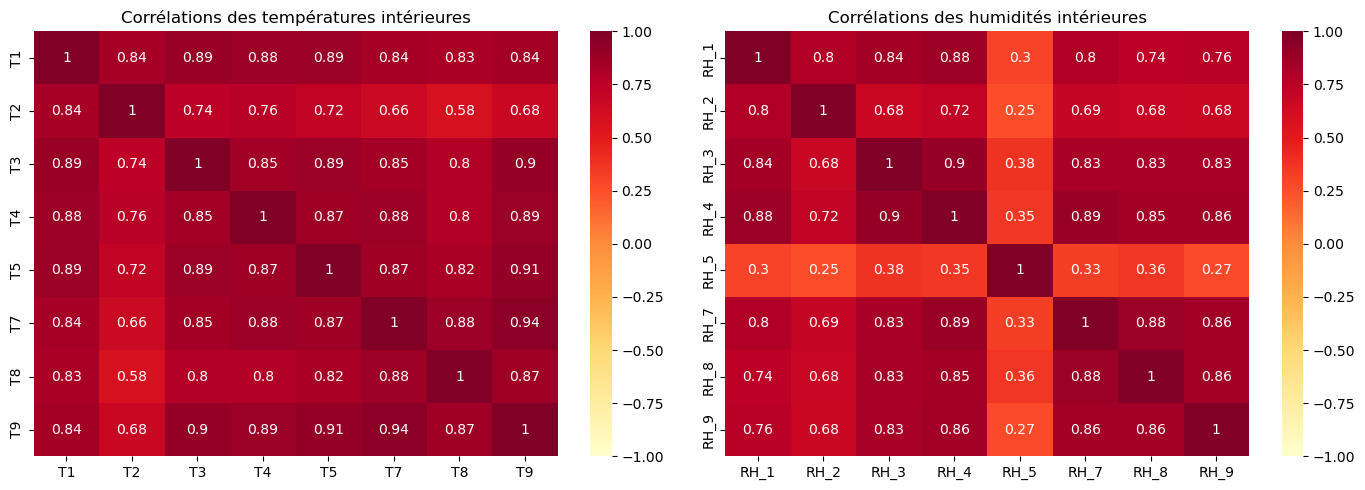

In [21]:
# Columns that represent the temperature and humidity inside the house
temp_cols = ['T1', 'T2', 'T3', 'T4', 'T5', 'T7', 'T8', 'T9']
hum_cols = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_7', 'RH_8', 'RH_9']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation matrix of indoor temperatures
sns.heatmap(df[temp_cols].corr(), annot=True, center=0, vmin=-1, vmax=1, cmap='YlOrRd', ax=axes[0])
axes[0].set_title("Corrélations des températures intérieures")

# Correlation matrix of indoor humidities
sns.heatmap(df[hum_cols].corr(), annot=True, center=0, vmin=-1, vmax=1, cmap='YlOrRd', ax=axes[1])
axes[1].set_title("Corrélations des humidités intérieures")

plt.tight_layout()
plt.show()

Toutes ces corrélations sont très élevées (souvent > 0.8), ce qui indique un risque important de **multicolinéarité** pouvant nuire à la stabilité et l’interprétabilité des modèles linéaires.

Les seules variables qui se différencient un peu sont `T2` (température dans le salon) et `RH_5` (humidité dans la salle de bain). Ce qui est logique car le salon est un lieu de vie particulier et l'humidité de la salle de bain dépend quasiment uniquement de l'usage de la douche et prend des valeurs bien plus élevées que les autres pièces. 

On va donc appliquer une **Analyse en Composantes Principales (ACP)** sur chaque groupe pour réduire la dimension de ces variables tout en conservant l’essentiel de l’information.


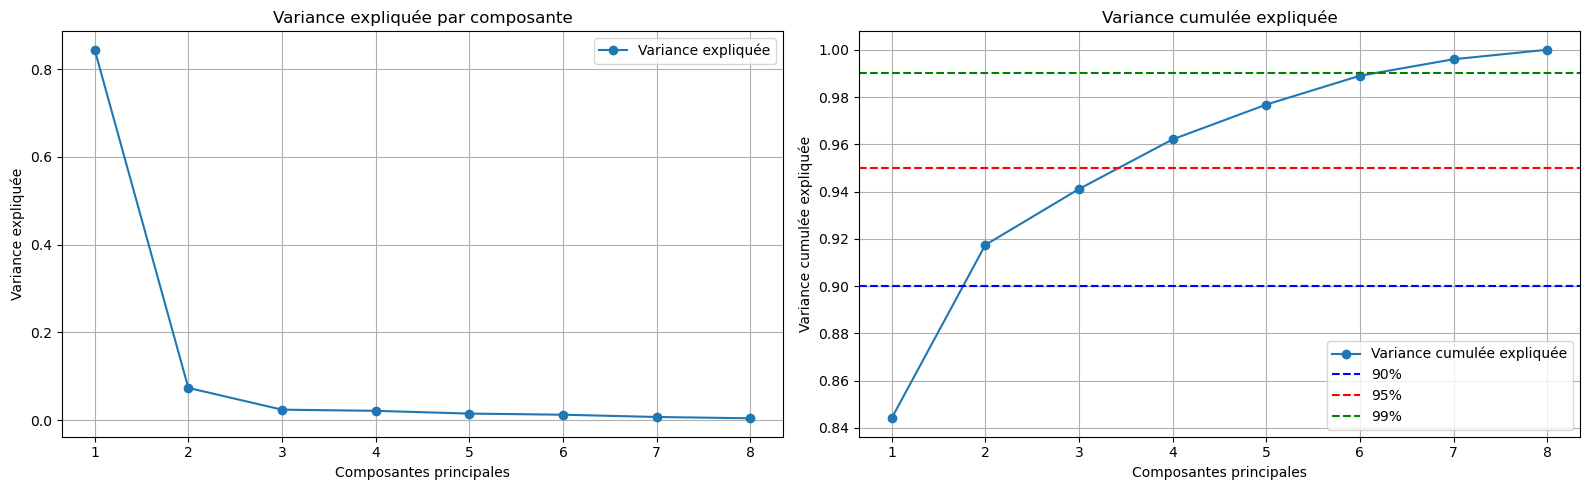

[0.84404304 0.91737796 0.94106173 0.96206803 0.97680183 0.98900026
 0.99599088 1.        ]


In [22]:
from sklearn.decomposition import PCA
import numpy as np

# PCA on the temperature columns
X_temp = df[temp_cols]
pca_temp = PCA().fit(X_temp)
explained_temp = pca_temp.explained_variance_ratio_
cumvar_temp = np.cumsum(explained_temp)


# Tracé de la variance expliquée et de la variance cumulée sur la même ligne
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Variance expliquée
axes[0].plot(range(1, len(explained_temp) + 1), explained_temp, marker='o', label='Variance expliquée')
axes[0].set_title("Variance expliquée par composante")
axes[0].set_xlabel("Composantes principales")
axes[0].set_ylabel("Variance expliquée")
axes[0].set_xticks(range(1, len(explained_temp) + 1))
axes[0].legend()
axes[0].grid()

# Variance cumulée expliquée
axes[1].plot(range(1, len(explained_temp) + 1), cumvar_temp, marker='o', label='Variance cumulée expliquée')
axes[1].set_title("Variance cumulée expliquée")
axes[1].set_xlabel("Composantes principales")
axes[1].set_ylabel("Variance cumulée expliquée")
axes[1].set_xticks(range(1, len(explained_temp) + 1))
axes[1].axhline(y=0.90, color='b', linestyle='--', label='90%')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95%')
axes[1].axhline(y=0.99, color='g', linestyle='--', label='99%')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

print(cumvar_temp)



On choisi de garder **les 2 premières composantes principales** puisque elles expliquent **92%** de la variance totale et qu'à partir de la 3ème composante, les gains en variance sont **très faibles et diminuent rapdidement**.

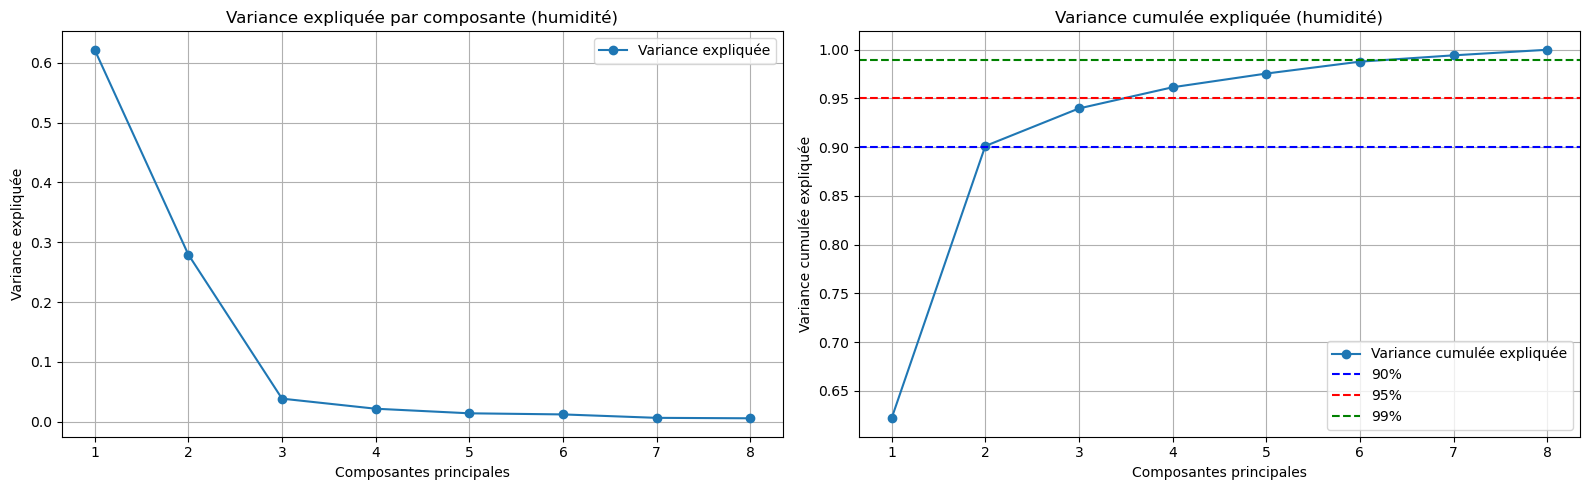

[0.62177835 0.90120466 0.93977558 0.96150808 0.97557611 0.98778643
 0.99427319 1.        ]


In [23]:
# ACP sur les colonnes d'humidité intérieure
X_hum = df[hum_cols]
pca_hum = PCA().fit(X_hum)
explained_hum = pca_hum.explained_variance_ratio_
cumvar_hum = np.cumsum(explained_hum)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Variance expliquée par composante
axes[0].plot(range(1, len(explained_hum) + 1), explained_hum, marker='o', label='Variance expliquée')
axes[0].set_title("Variance expliquée par composante (humidité)")
axes[0].set_xlabel("Composantes principales")
axes[0].set_ylabel("Variance expliquée")
axes[0].set_xticks(range(1, len(explained_hum) + 1))
axes[0].legend()
axes[0].grid()

# Variance cumulée expliquée
axes[1].plot(range(1, len(cumvar_hum) + 1), cumvar_hum, marker='o', label='Variance cumulée expliquée')
axes[1].set_title("Variance cumulée expliquée (humidité)")
axes[1].set_xlabel("Composantes principales")
axes[1].set_ylabel("Variance cumulée expliquée")
axes[1].set_xticks(range(1, len(cumvar_hum) + 1))
axes[1].axhline(y=0.90, color='b', linestyle='--', label='90%')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95%')
axes[1].axhline(y=0.99, color='g', linestyle='--', label='99%')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

print(cumvar_hum)

Pour les même raisons, on garde aussi les **2 premières composantes**. Elles expliquent ici **90%** de la variance totale.

On va donc créer 4 nouvelles variables `PC_temp1`, `PC_temp2`, `PC_hum1` et `PC_hum2` qui seront les deux premières composantes principales de chaque groupe de variables.

In [24]:
temp_pcs = pca_temp.transform(df[temp_cols])
df['PC_temp1'] = temp_pcs[:, 0]
df['PC_temp2'] = temp_pcs[:, 1]

hum_pcs = pca_hum.transform(df[hum_cols])
df['PC_hum1'] = hum_pcs[:, 0]
df['PC_hum2'] = hum_pcs[:, 1]


>**Conclusion :**
>
> - Nous somme passer de **16** variables à **4** variables, ce qui réduit considérablement la **multicolinéarité** et est censé améliorer la **stabilité** des modèles linéaires. 
> - Nous avons gardé plus de **90%** de la variance totale dans les deux groupes. 
> - Nous testerons plus tard l'impact des ces nouvelles variables sur les performances des modèles.

### 4.3 Transformation de la cible

Comme on l'a vu précédemment, la distribution de la consommation `Appliances` est fortement asymétrique à droite et présente des outliers marqués :

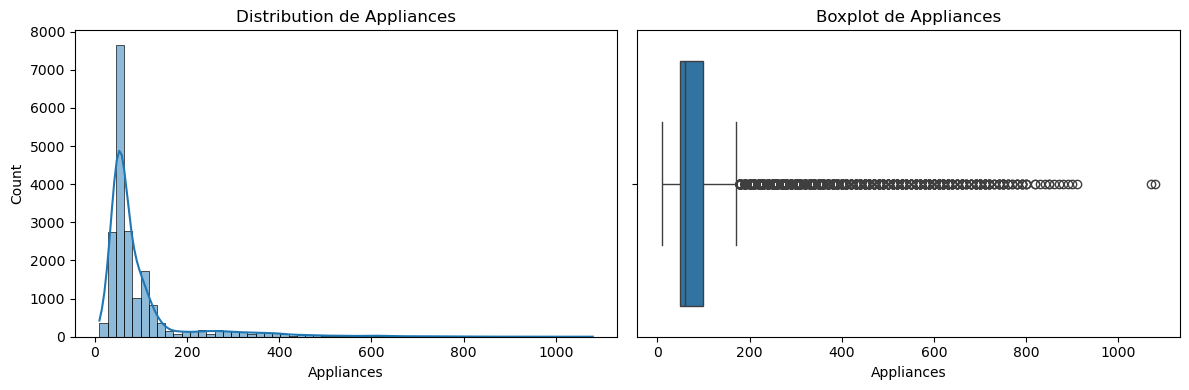

In [25]:
# Original distribution of Appliances
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['Appliances'], bins=60, kde=True, ax=axes[0])
axes[0].set_title("Distribution de Appliances")
sns.boxplot(x=df['Appliances'], ax=axes[1])
axes[1].set_title("Boxplot de Appliances")
plt.tight_layout()
plt.show()

- **Asymétrie prononcée** (longue queue à droite)  
- **Variance non constante** (outliers très éloignés du corps principal)  
- Ces caractéristiques peuvent biaiser le **MSE** et violer **l’homoscédasticité** (variance non constante).

On le remarque aussi sur la série temporelle de `Appliances` qui présente une forte volatilité et des outliers marqués :

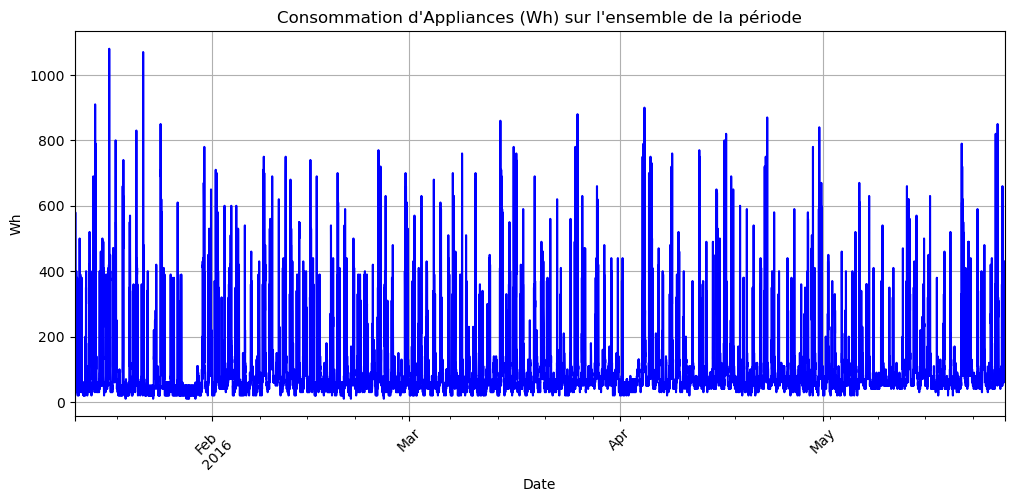

In [26]:
# Plot appliances complete time series
plt.figure(figsize=(12, 5))
df['Appliances'].plot(color='blue')
plt.title("Consommation d'Appliances (Wh) sur l'ensemble de la période")
plt.xlabel("Date")
plt.ylabel("Wh")
plt.xticks(rotation=45)
plt.grid()
plt.show()

On va donc appliquer une **transformation logarithmique** sur la cible `Appliances` pour réduire l’asymétrie et stabiliser la variance.

In [27]:
# Application du log-transform pour atténuer ces effets
df['log_Appliances'] = np.log1p(df['Appliances'])

# Mesure de la skewness avant/après
skew_orig = df['Appliances'].skew()
skew_log  = df['log_Appliances'].skew()
print(f"Skewness avant : {skew_orig:.2f}")
print(f"Skewness après : {skew_log:.2f}")

Skewness avant : 3.39
Skewness après : 1.19


La transformation `log1p` permet de :  
- **Réduire l’asymétrie** et rapprocher la distribution d’une forme plus gaussienne  
- **Stabiliser la variance**, améliorant l’homoscédasticité des résidus  
- Mieux modéliser les **effets multiplicatifs** (variation en pourcentage)

Distribution et série temporelle après transformation :

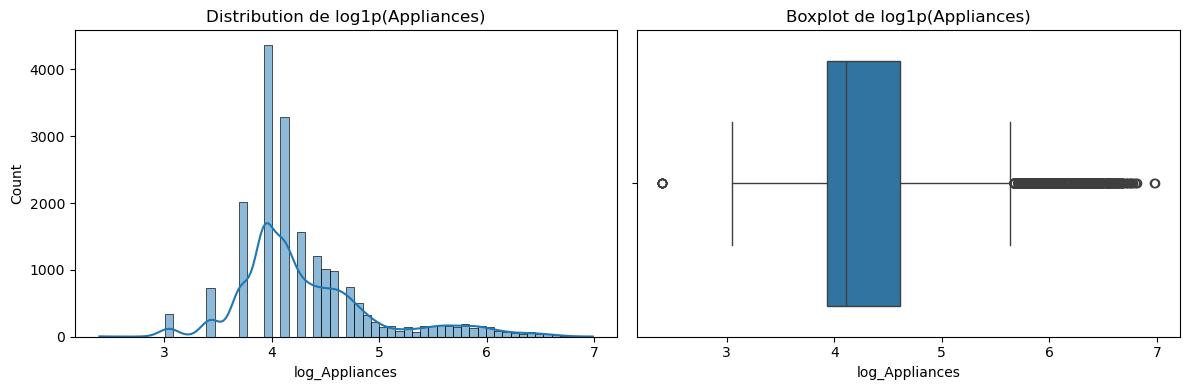

In [28]:
# Distribution après transformation
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['log_Appliances'], bins=60, kde=True, ax=axes[0])
axes[0].set_title("Distribution de log1p(Appliances)")
sns.boxplot(x=df['log_Appliances'], ax=axes[1])
axes[1].set_title("Boxplot de log1p(Appliances)")
plt.tight_layout()
plt.show()

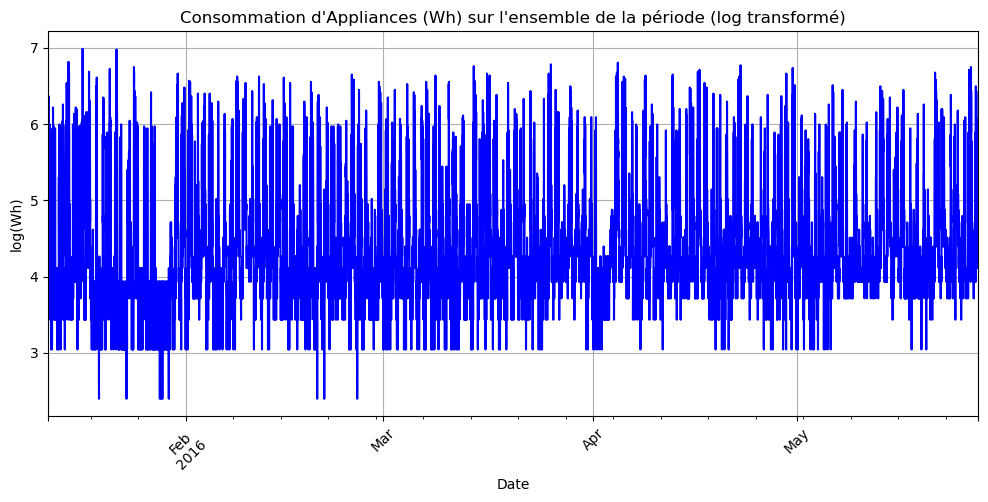

In [29]:
# Plot log transformed appliances time series
plt.figure(figsize=(12, 5))
df['Appliances'].apply(np.log1p).plot(color='blue')
plt.title("Consommation d'Appliances (Wh) sur l'ensemble de la période (log transformé)")
plt.xlabel("Date")
plt.ylabel("log(Wh)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

> **Conclusion :**
>
> - Le `log1p` sur la cible rend la distribution plus **symétrique**
> - Il **atténue l’impact des valeurs extrêmes** et **stabilise la variance**
> - Cela se traduit généralement par de meilleures performances et une interprétation plus robuste des modèles de régression notamment linéaires. (On testera ce plus tard)
> - On remarque graphiquement ces changements : la distribution est plus symétrique et la série temporelle est plus lissée, ce qui est un bon signe pour la modélisation.
> - Mais, cette transformation **n'est pas parfaite** puisqu'il reste encore une légère asymétrie et des outliers.


### 4.4 Lags et statistiques glissantes

L’analyse descriptive a mis en évidence :  
- Une **forte autocorrélation intra-journalière** : la consommation à 10 min, 30 min ou 1 h d’intervalle reste très similaire.  
- Des **pics localisés** qui se prolongent sur plusieurs intervalles de temps (de plusieurs dizaines de minutes à plusieurs heures).  

Les **lags** exploitent ces propriétés :  
- **Mémoire du contexte** – fournir `Appliances_{t−k}` (k=1,6,12…) permet au modèle de prolonger les tendances récentes.  
- **Alerte précoce aux pics** – un pic à t−1 signale fortement qu’un pic à t est probable.  

Les **statistiques glissantes** (rolling) :  
- **Lissent** les fluctuations (moyennes mobiles)  
- Quantifient la **volatilité locale** (écart-type mobile)  


In [30]:
# Création de lags de la cible
lags = [1, 6, 12, 24]  # en pas de 10 min : 1→10 min, 6→1 h, 12→2 h, 24→4 h
for lag in lags:
    df[f'lag_{lag}'] = df['Appliances'].shift(lag)
    df[f'lag_log_{lag}'] = df['log_Appliances'].shift(lag)

Les lags ajoutent une **mémoire** temporaire :  
- `lag_1` capture l’effet “10 min avant”,  
- `lag_6` celui “1 h avant”, etc.  

In [31]:
# Rolling mean and std
windows = [6, 12, 24, 72]  # 1 h, 2 h, 4 h, 12 h
for w in windows:
    df[f'roll_mean_{w}'] = df['Appliances'].rolling(window=w, min_periods=1).mean()
    df[f'roll_std_{w}']  = df['Appliances'].rolling(window=w, min_periods=1).std().fillna(0)
    df[f'roll_mean_log_{w}'] = df['log_Appliances'].rolling(window=w, min_periods=1).mean()
    df[f'roll_std_log_{w}']  = df['log_Appliances'].rolling(window=w, min_periods=1).std().fillna(0)

- `roll_mean_w` : moyenne mobile sur `w × 10 min`,  
- `roll_std_w` : écart-type mobile → mesure la volatilité locale.  

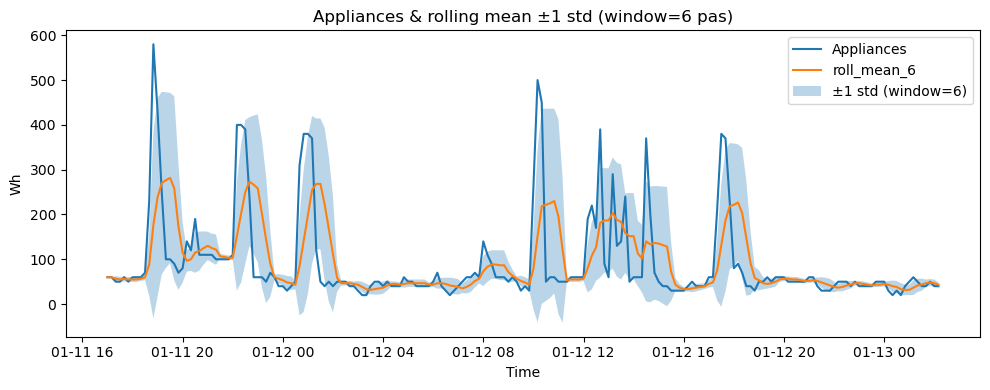

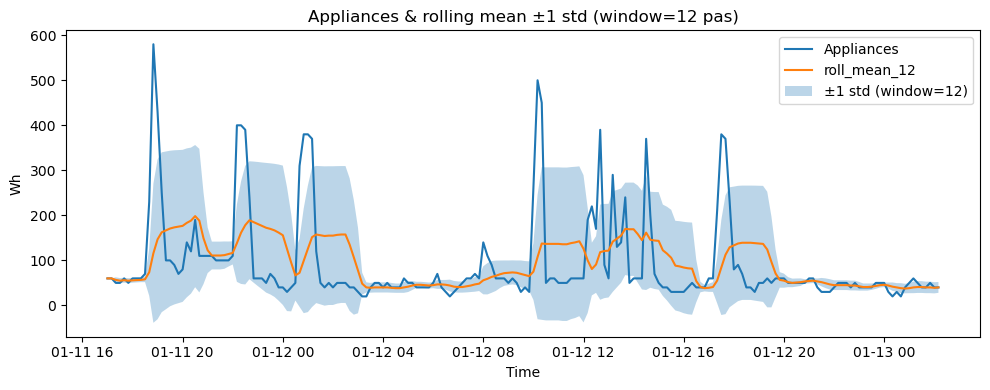

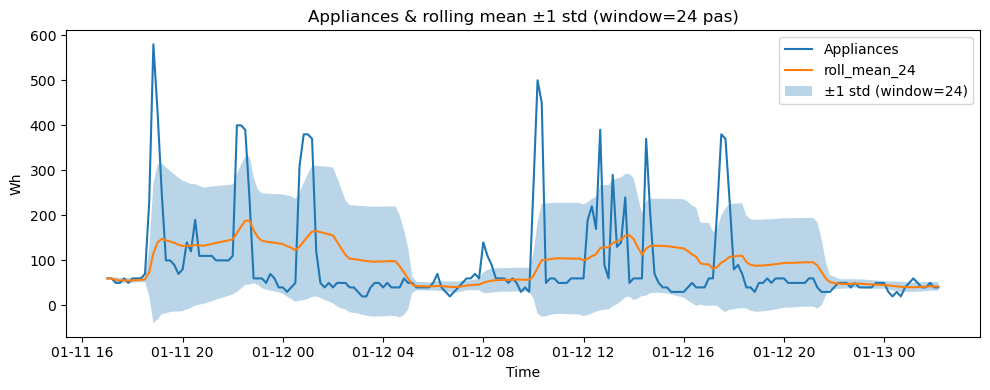

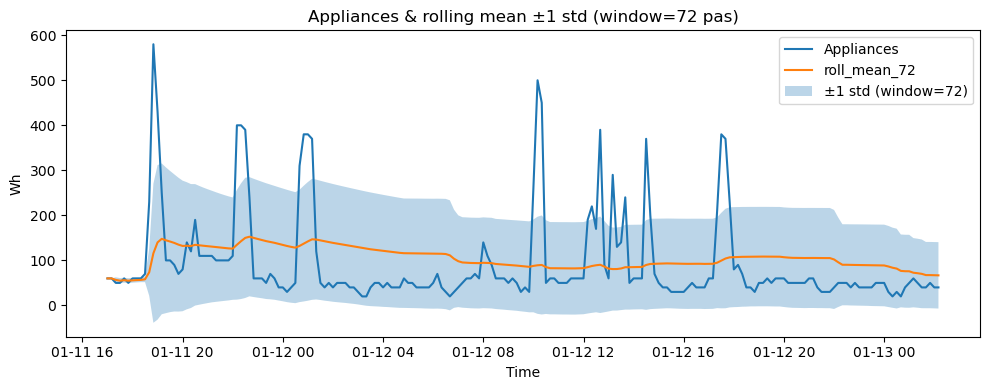

In [32]:
import matplotlib.pyplot as plt

# Fenêtres de calcul : 1h, 2h, 4h, 12h (en pas de 10 min)
windows = [6, 12, 24, 72]
n = 200  # nombre de points à afficher pour la lisibilité

for w in windows:
    # Calcul des rolling mean et rolling std
    roll_mean = df['Appliances'].rolling(window=w, min_periods=1).mean()
    roll_std  = df['Appliances'].rolling(window=w, min_periods=1).std().fillna(0)
    
    # Trace
    plt.figure(figsize=(10, 4))
    plt.plot(df.index[:n], df['Appliances'][:n], label='Appliances')
    plt.plot(df.index[:n], roll_mean[:n], label=f'roll_mean_{w}')
    plt.fill_between(
        df.index[:n],
        roll_mean[:n] - roll_std[:n],
        roll_mean[:n] + roll_std[:n],
        alpha=0.3,
        label=f'±1 std (window={w})'
    )
    
    plt.title(f'Appliances & rolling mean ±1 std (window={w} pas)')
    plt.xlabel('Time')
    plt.ylabel('Wh')
    plt.legend()
    plt.tight_layout()
    plt.show()


Les graphiques ci-dessus comparent la série brute `Appliances` à la **moyenne mobile** et à la bande **±1 écart-type** pour quatre tailles de fenêtres
(1, 2, 4 et 12h heures).

**Interprétation :**  
- Les **petites fenêtres** (1-2h) permettent de détecter et prolonger les **pics localisés**.  
- Les **grandes fenêtres** (4-12h) fournissent une **tendance de fond**, utile pour capturer les cycles jour/nuit ou la variation hebdomadaire.  
- L’**écart-type mobile** permet au modèle de quantifier la **volatilité locale**, renforçant la capacité à prédire l’intensité et la durée des pointes.

En combinant plusieurs tailles de fenêtres (`roll_mean_w`, `roll_std_w`), on apporte au modèle à la fois une mémoire fine des fluctuations rapides et une vision plus globale de la tendance, ce qui améliore la robustesse et la précision des prédictions.

>**Conclusion :**
>
> - les **lags** fournissent une mémoire contextuelle et alertent sur les pics prolongés
> - les **rolling stats** lissent le signal et mesurent la volatilité locale
> - Il faudra quand même vérifier que ces nouvelles variables ne créent pas de **multicolinéarité** avec les autres variables explicatives.
> - Il faudra surement utiliser des techniques de **regularisation** (Lasso, Ridge) pour éviter le sur-apprentissage.
> - Aussi, il faudra faire attention à la **taille de la fenêtre** choisie. 

### Conclusion de la partie 4 – Feature Engineering



En se basant sur notre exploration des données, nous les avons enrichi avec des indicateurs pertinents (occupation, temporalité, lags, moyennes mobiles, ACP, log) qui on l'espère améliorerons les performances. Mais, en se faisant, on a ajouté de la multicolinéarité et de la complexité au modèle. 

Dans les parties suivantes, nous allons : 
- entraîner nos différents algorithmes (linéaires, réseau de neurones, noyaux...) et comparer leurs performances avec et sans ces nouvelles variables. 
- on verras quelles variables sont plus ou moins importantes pour chaque algorithme, pourquoi et comment elles influencent la prédiction
- on aura donc pour chaque modèle un jeu de features optimal propre à ce modèle. 
- on essayera aussi de trouver les hyperparamètres optimaux pour chaque algorithme.

Ainsi, nous étudierons les spécificités de chaque algorithme tout en atteignant des performances (on l'espère) optimales.

# 5. Préparation des données

### 5.1 Nettoyage

En créant de nouvelles variables temporelles dans le feature engineering, on a introduit des **valeurs manquantes**. Il n'y en a pas beaucoup donc on va les supprimer.

In [33]:
# Afficher le nombre de valeurs manquantes par colonne dans df
missing = df.isnull().sum()
print(missing[missing > 0])

# delete
df = df.dropna()

lag_1          1
lag_log_1      1
lag_6          6
lag_log_6      6
lag_12        12
lag_log_12    12
lag_24        24
lag_log_24    24
dtype: int64


In [34]:
df.shape 

(19711, 58)

### 5.2 Définition des features-sets

Comme on l'a dit précédemment, on va juger la pertinence des features ajoutées en fonction des différents algorithmes. 

On ne pourra pas tester **toutes les combinaisons** possibles, ni **l'impact individuel** de chaque feature pour garder la longueur de ce notebook raisonnable. Mais on va essayer d'analyser ces features **par groupe**. 

Pour cela, on créé des **features-sets** qui contiennent les variables qu'on va utiliser pour chaque algorithme.
- `FS0` : toutes les variables explicatives de base (sans la partie feature engineering)
- `FS1` : `FS0` + les variables temporelles (`hour`, `dayofweek`) + l'indicateur d'occupation (`occupancy`) 
- `FS2` : `FS1` + l'acp sur les températures et humidités (sans les variables de base)
- `FS3` : `FS2` + les lags et rolling stats de `Appliances`
- `FS3_log` : `FS2` + les lags et rolling stats de `log_appliances` 

Ca nous permettra d'étudier l'apport incrémental du feature engineering.

On entrainera alors chaque algorithme sur ces 4 features-sets et on comparera les performances.

In [35]:
# FS0 : variables d’origine (sans temporalité ni PCA ni lags/rolling)
fs0 = [
    'lights', 'T1','RH_1','T2','RH_2','T3','RH_3','T4','RH_4',
    'T5','RH_5','T6','RH_6','T7','RH_7','T8','RH_8','T9','RH_9',
    'T_out','RH_out','Windspeed','Visibility','Tdewpoint','Press_mm_hg'
]

# FS1 : FS0 + indicateurs temporels et d’occupation
fs1 = fs0 + ['hour','dayofweek','occupancy']

# FS2 : FS1 + composantes principales (PCA) - température - humidité
temp_hum_cols = [
    'T1','RH_1','T2','RH_2','T3','RH_3','T4','RH_4',
    'T5','RH_5','T7','RH_7','T8','RH_8','T9','RH_9'
]
fs2 = [col for col in fs1 if col not in temp_hum_cols] + ['PC_temp1', 'PC_temp2', 'PC_hum1', 'PC_hum2']

# FS3 : FS2 + lags et statistiques glissantes
lags    = [1,6,12,24]     # en pas de 10 min
windows = [6,12,24,72]    # 1h, 2h, 4h, 12h
fs3 = fs2 + [f'lag_{l}' for l in lags] + [f'roll_mean_{w}' for w in windows] + [f'roll_std_{w}' for w in windows]
fs3_log = fs2 + [f'lag_log_{l}' for l in lags] + [f'roll_mean_log_{w}' for w in windows] + [f'roll_std_log_{w}' for w in windows]

feature_sets = {'FS0': fs0, 'FS1': fs1, 'FS2': fs2, 'FS3': fs3, 'FS3_log': fs3_log}

# nombre de features par feature set
print("Nombre de features par feature set :")
for fs, cols in feature_sets.items():
    print(f"{fs} : {len(cols)}")

Nombre de features par feature set :
FS0 : 25
FS1 : 28
FS2 : 16
FS3 : 28
FS3_log : 28


### 4.3 Découpage des données

On va faire un split **train/test chronologique** 80/20. On ne créé pas de **dev set** puisqu'on va fine tuner nos modèles grâce à la validation croisée. 

On va créer deux Y différent pour la cible `Appliances` et la cible `log_Appliances` (log transformée).

In [36]:
n = len(df)
cutoff = int(0.8 * n)

X_train = df.iloc[:cutoff].drop(columns=['Appliances', 'log_Appliances'])
X_test = df.iloc[cutoff:].drop(columns=['Appliances', 'log_Appliances'])

y_train, y_train_log = df.iloc[:cutoff]['Appliances'], df.iloc[:cutoff]['log_Appliances']
y_test, y_test_log = df.iloc[cutoff:]['Appliances'], df.iloc[cutoff:]['log_Appliances']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15768, 56), (3943, 56), (15768,), (3943,))

### 4.4 Normalisation des données

En dessous, on trace les **boxplot** pour le feature set `FS3` pour illustrer la nécessité de **normaliser les données**.

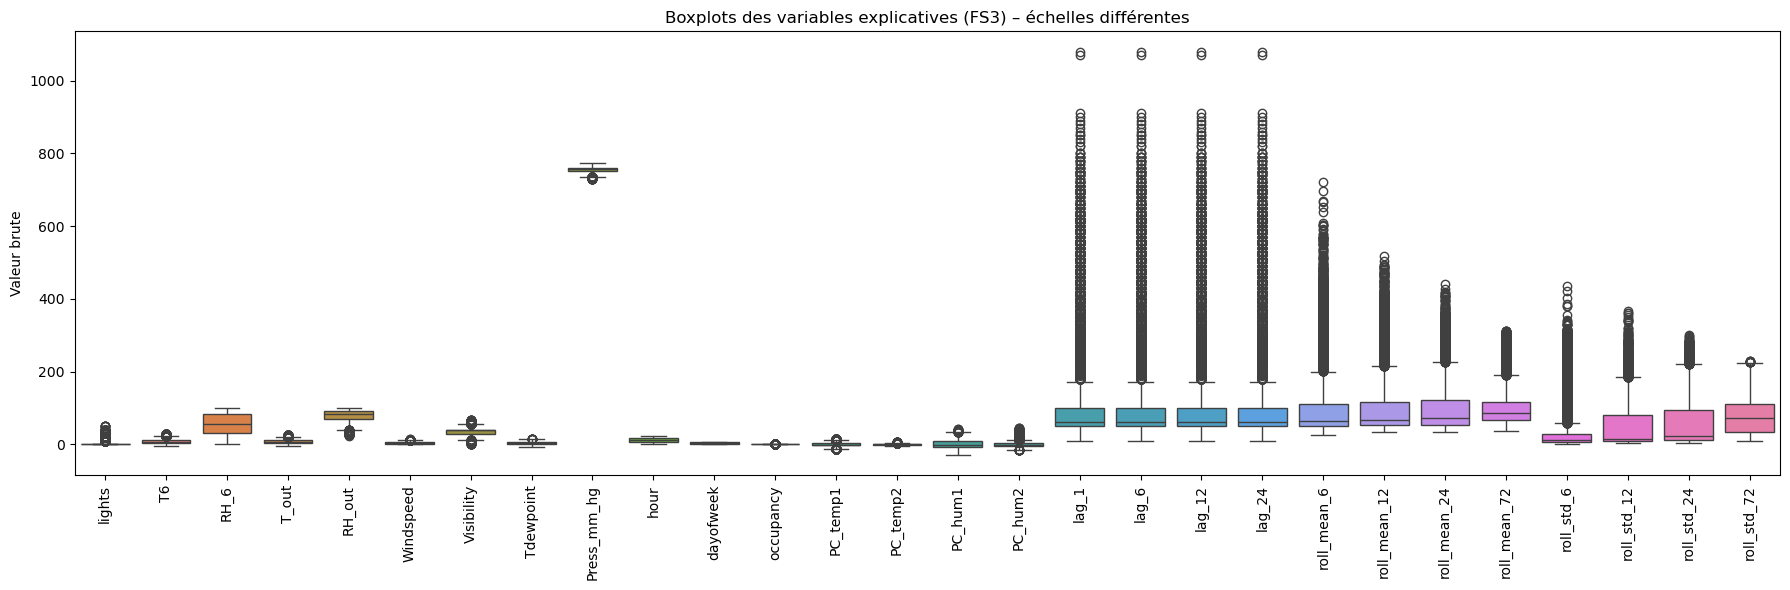

In [37]:
# Boxplots des variables explicatives pour montrer la différence d'échelle
plt.figure(figsize=(18, 6))
sns.boxplot(data=df[feature_sets['FS3']])
plt.xticks(rotation=90)
plt.title("Boxplots des variables explicatives (FS3) – échelles différentes")
plt.ylabel("Valeur brute")
plt.tight_layout()
plt.show()

Comme on peut le voir, les variables ont des **échelles très différentes**, il est donc nécessaire de les mettre sur la même échelle pour éviter que certaines variables dominent les autres dans les modèles.

On va utiliser un **StandardScaler** pour **centrer et réduire** les variables fittées **sur l'échantillon d'apprentissage** pour éviter d'utiliser des informations du test.

In [38]:
from sklearn.preprocessing import StandardScaler

# On normalise selon les features du train uniquement (pas de fuite d'information)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

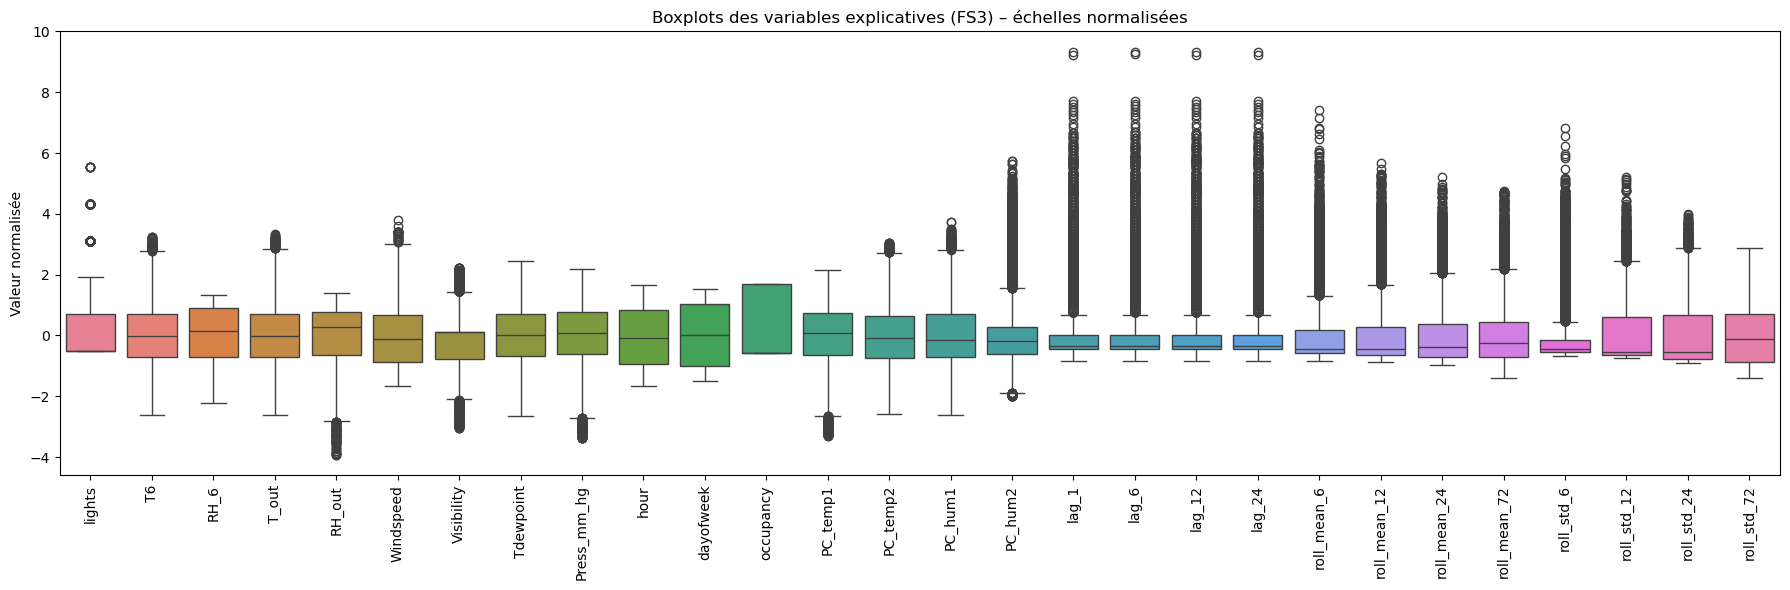

In [39]:
# Convert X_train_scaled back to DataFrame with correct column names for FS3
import pandas as pd

plt.figure(figsize=(18, 6))
sns.boxplot(data=X_train_scaled_df[feature_sets['FS3']])
plt.xticks(rotation=90)
plt.title("Boxplots des variables explicatives (FS3) – échelles normalisées")
plt.ylabel("Valeur normalisée")
plt.tight_layout()
plt.show()

La différence est claire, on bien normalisé les données.

Comme on va utiliser un **réseau de neuronnes** plus tard, on normalise aussi les cibles `Appliances` et `log_Appliances`.  

Cette **double-normalisation** (X et y) place l’ensemble du problème dans une **zone numérique stable** pour **la descente de gradient**, **accélère la convergence** et permet d’utiliser un **learning rate modéré**.

Nous l'illustrerons ou détaillerons pourquoi plus tard si il reste de la place. 

In [40]:
from sklearn.preprocessing import StandardScaler

# Normalisation des cibles (train/test, Appliances et log_Appliances)

# Initialiser les scalers pour chaque cible
y_scaler = StandardScaler()
y_log_scaler = StandardScaler()

# Fit sur le train uniquement, transform sur train et test
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

y_train_log_scaled = y_log_scaler.fit_transform(y_train_log.values.reshape(-1, 1)).flatten()
y_test_log_scaled = y_log_scaler.transform(y_test_log.values.reshape(-1, 1)).flatten()

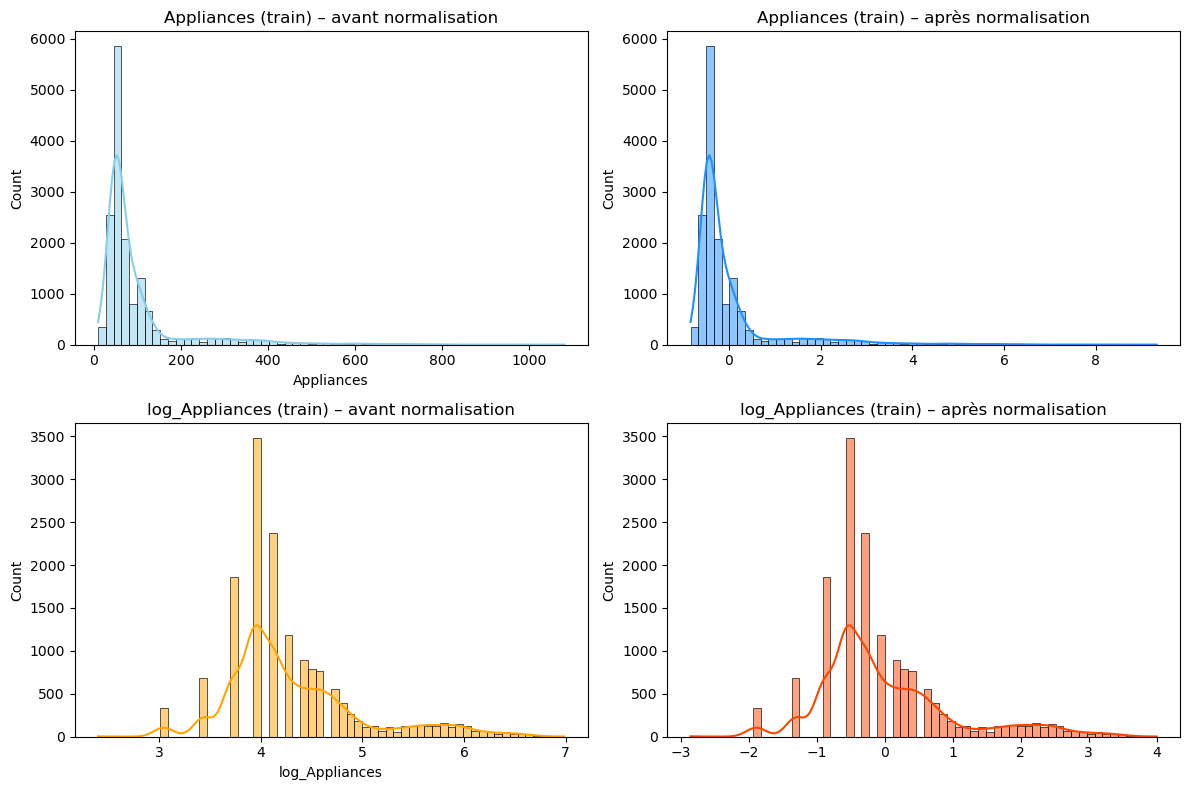

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Distribution originale de la cible Appliances
sns.histplot(y_train, bins=60, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("Appliances (train) – avant normalisation")

# Distribution normalisée de la cible Appliances
sns.histplot(y_train_scaled, bins=60, kde=True, ax=axes[0, 1], color='dodgerblue')
axes[0, 1].set_title("Appliances (train) – après normalisation")

# Distribution originale de la cible log_Appliances
sns.histplot(y_train_log, bins=60, kde=True, ax=axes[1, 0], color='orange')
axes[1, 0].set_title("log_Appliances (train) – avant normalisation")

# Distribution normalisée de la cible log_Appliances
sns.histplot(y_train_log_scaled, bins=60, kde=True, ax=axes[1, 1], color='orangered')
axes[1, 1].set_title("log_Appliances (train) – après normalisation")

plt.tight_layout()
plt.show()


# 6. Modélisation

In [42]:
def get_X(fs, which='train', scaled=True):
    """
    Renvoie X_train ou X_test, scaled ou non, pour le feature set fs.
    """
    df_X = (X_train_scaled_df if which=='train' else X_test_scaled_df) if scaled \
           else (X_train if which=='train' else X_test)
    return df_X[feature_sets[fs]].values

def get_y(target='raw', which='train', scaled=False):
    """
    Renvoie y_train ou y_test, raw/log, scaled ou non.
    """
    if target == 'raw':
        arr = (y_train_scaled   if which=='train' else y_test_scaled)
        true = (y_train.values  if which=='train' else y_test.values)
    else:
        arr = (y_train_log_scaled if which=='train' else y_test_log_scaled)
        true = (np.expm1(y_train_log.values) if which=='train'
                else np.expm1(y_test_log.values))
    return arr if scaled else (y_train.values if which=='train' and target=='raw' 
                                else (y_train_log.values if which=='train'
                                      else true))

def invert_y(y_pred, target='raw', scaled=False):
    """
    Inverse log1p + StandardScaler si besoin, retourne en Wh.
    """
    if target == 'raw':
        return y_scaler.inverse_transform(y_pred.reshape(-1,1)).ravel() if scaled else y_pred
    else:
        y_log = (y_log_scaler.inverse_transform(y_pred.reshape(-1,1)).ravel() 
                 if scaled else y_pred)
        return np.expm1(y_log)

def run_model(model, fs, target='raw', X_scaled=True, y_scaled=False):
    # 1. Prépare les données
    X_tr = get_X(fs, 'train', scaled=X_scaled)
    X_te = get_X(fs, 'test',  scaled=X_scaled)
    y_tr = get_y(target, 'train', scaled=y_scaled)
    y_te = get_y(target, 'test',  scaled=y_scaled)
    y_te_true = get_y(target, 'test', scaled=False)  # en Wh

    # 2. Fit & predict
    model.fit(X_tr, y_tr)
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)

    # 3. Inversion en Wh
    y_pred_tr_raw = invert_y(y_pred_tr, target, y_scaled)
    y_pred_te_raw = invert_y(y_pred_te, target, y_scaled)

    # 4. Metrics
    def metrics(y_true, y_pred):
        return {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE':  mean_absolute_error(y_true, y_pred),
            'R2':   r2_score(y_true, y_pred)
        }

    train_m = metrics(get_y('raw','train',scaled=False), y_pred_tr_raw)
    test_m  = metrics(y_te_true,                   y_pred_te_raw)

    # 5. Retourne tout
    results = {
        'model':    model,
        'features': fs,
        'target':   target,
        'X_scaled':X_scaled,
        'y_scaled':y_scaled,
        **{f'train_{k}': v for k,v in train_m.items()},
        **{f'test_{k}':  v for k,v in test_m.items()},
        'y_pred_train': y_pred_tr_raw,
        'y_true_train': get_y('raw','train',scaled=False),
        'y_pred_test':  y_pred_te_raw,
        'y_true_test':  y_te_true
    }
    return results

def display_results(res):
    print(f"{res['model'].__class__.__name__} — {res['features']} — {res['target']}  "
          f"(X_scaled={res['X_scaled']}, y_scaled={res['y_scaled']})")
    for split in ('train','test'):
        print(f" {split.upper():5}  RMSE {res[f'{split}_RMSE']:.2f}  "
              f"MAE {res[f'{split}_MAE']:.2f}  R2 {res[f'{split}_R2']:.3f}")

def plot_results(res, split='both'):
    """
    Affiche les résultats du modèle pour le train, le test, ou les deux.
    split: 'train', 'test', ou 'both'
    """
    y_tr, yp_tr = res['y_true_train'], res['y_pred_train']
    y_te, yp_te = res['y_true_test'],  res['y_pred_test']

    if split == 'train':
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        # train pred vs true
        axes[0].scatter(y_tr, yp_tr, alpha=0.3)
        axes[0].plot([y_tr.min(),y_tr.max()],[y_tr.min(),y_tr.max()],'k--')
        axes[0].set_title("Train : préd vs réelles")
        # train résidus
        axes[1].hist(y_tr-yp_tr, bins=50)
        axes[1].set_title("Train : résidus")
    elif split == 'test':
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        # test pred vs true
        axes[0].scatter(y_te, yp_te, alpha=0.3)
        axes[0].plot([y_te.min(),y_te.max()],[y_te.min(),y_te.max()],'k--')
        axes[0].set_title("Test  : préd vs réelles")
        # test résidus
        axes[1].hist(y_te-yp_te, bins=50)
        axes[1].set_title("Test  : résidus")
    else:
        fig, axes = plt.subplots(2,2, figsize=(12,10))
        # train pred vs true
        axes[0,0].scatter(y_tr, yp_tr, alpha=0.3)
        axes[0,0].plot([y_tr.min(),y_tr.max()],[y_tr.min(),y_tr.max()],'k--')
        axes[0,0].set_title("Train : préd vs réelles")
        # test pred vs true
        axes[0,1].scatter(y_te, yp_te, alpha=0.3)
        axes[0,1].plot([y_te.min(),y_te.max()],[y_te.min(),y_te.max()],'k--')
        axes[0,1].set_title("Test  : préd vs réelles")
        # train résidus
        axes[1,0].hist(y_tr-yp_tr, bins=50)
        axes[1,0].set_title("Train : résidus")
        # test résidus
        axes[1,1].hist(y_te-yp_te, bins=50)
        axes[1,1].set_title("Test  : résidus")
    plt.tight_layout()
    plt.show()

## 6.1 Modèles linéaires

On va commencer par les **modèles linéaires**, qui sont les plus rapide à entraîner/tester et à interpréter. 

Ils représentent souvent une **bonne première approche** pour un premier "état des lieux" avant de passer à des modèles plus complexes.


### a) OLS

Ici, nous allons commencer la prédiction avec le modèle linéaire **OLS classique**. 

Nous allons :
- Voir en détail comment le modèle se comporte sur les **données brutes**
- Analyser la pertinence de la **normalisation** des données pour cet estimateur
- Quantifier l'impact de la **transformation log** de la cible
- Tester l'impact des différents **features-sets** sur les performances, voir lesquels sont les plus **pertinents** et **quantifier** leur apport
- Voir si il y a une différence entre les performances sur le **train** et le **test** (overfitting ?)


#### i) Performances sur les données brutes

On commence par la régression linéaire simple sur le **feature set 0** (sans feature engineering) avec les **données brutes** (pas de normalisation ou de log). 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sélection des features et de la cible pour FS0
X_train_fs0 = X_train[feature_sets['FS0']]
X_test_fs0 = X_test[feature_sets['FS0']]
y_train_fs0 = y_train
y_test_fs0 = y_test

# Entraînement du modèle
lr = LinearRegression()
lr.fit(X_train_fs0, y_train_fs0)

# Prédictions
y_pred_train = lr.predict(X_train_fs0)
y_pred_test = lr.predict(X_test_fs0)

# Calcul des métriques
# Calcul des métriques séquentiellement sans fonction

print("Résultats régression linéaire sur données brutes:")

rmse_train = np.sqrt(mean_squared_error(y_train_fs0, y_pred_train))
mae_train = mean_absolute_error(y_train_fs0, y_pred_train)
r2_train = r2_score(y_train_fs0, y_pred_train)

print(f"Train RMSE: {rmse_train:.2f}")
print(f"Train  MAE: {mae_train:.2f}")
print(f"Train   R2: {r2_train:.3f}")
      

rmse_test = np.sqrt(mean_squared_error(y_test_fs0, y_pred_test))
mae_test = mean_absolute_error(y_test_fs0, y_pred_test)
r2_test = r2_score(y_test_fs0, y_pred_test)

print(f"Test  RMSE: {rmse_test:.2f}")
print(f"Test   MAE: {mae_test:.2f}")
print(f"Test    R2: {r2_test:.3f}")

Résultats régression linéaire sur données brutes:
Train RMSE: 95.75
Train  MAE: 54.36
Train   R2: 0.173
Test  RMSE: 86.10
Test   MAE: 51.76
Test    R2: 0.095




- **RMSE (Test) ≃ 86.10 Wh**  
  Très proche de l’écart-type de la cible (~ 102 Wh) : notre modèle ne parvient quasiment pas à réduire la dispersion intrinsèque des consommations et ne fait pas beaucoup mieux qu’un prédicteur constant (la moyenne).

- **MAE (Test) ≃ 51.76 Wh**  
  En moyenne, nos prédictions s’écartent d’environ ± 52 Wh des valeurs réelles. Ce qui est la moitié de la consommation moyenne (~ 98 Wh) donc très élevé.

- **R² (Test) ≃ 0.095**  
  Seul 9.5 % de la variance est expliqué : l’essentiel de la variabilité de la consommation reste non capturé par ce modèle linéaire simple. D'où l'importance du feature engineering.

- **Train vs Test** 
    Le RMSE/MAE meilleur en test malgré un R² en baisse révèle une variance cible plus faible (et non du surapprentissage) et souligne que le modèle linéaire est trop simple pour capturer les non-linéarités et interactions des données.


On va afficher les **résidus** pour montrer que le modèle n'est pas bien ajusté. 


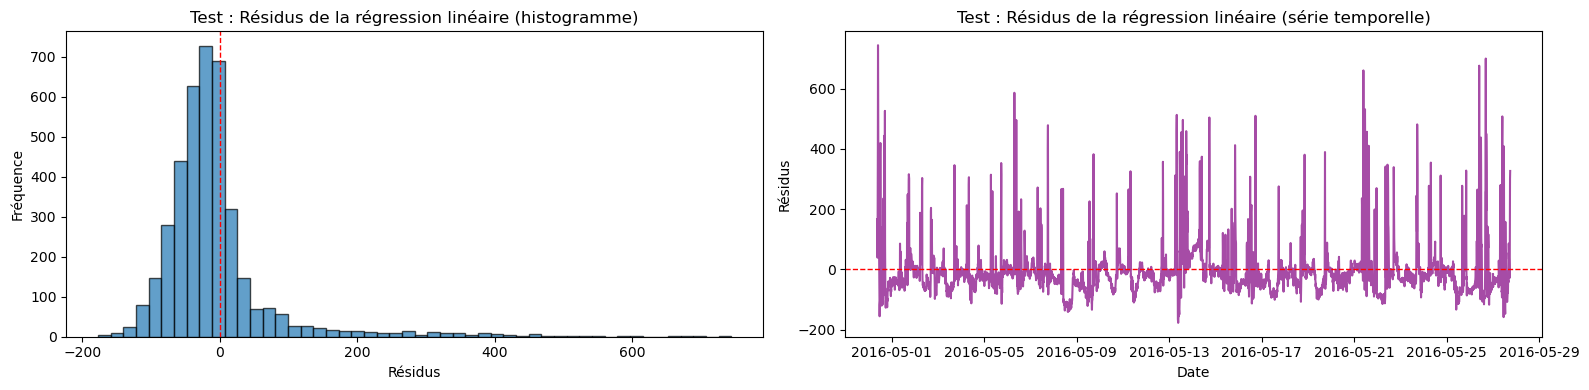

In [44]:
# Test : résidus (histogramme + série temporelle)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Histogramme des résidus
axes[0].hist(y_test_fs0 - y_pred_test, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title("Test : Résidus de la régression linéaire (histogramme)")
axes[0].set_xlabel("Résidus")
axes[0].set_ylabel("Fréquence")
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)

# Série temporelle des résidus
axes[1].plot(y_test_fs0.index, y_test_fs0 - y_pred_test, color='purple', alpha=0.7)
axes[1].set_title("Test : Résidus de la régression linéaire (série temporelle)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Résidus")
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

La distribution des résidus est **asymétrique à droite**, indiquant la présence **d'outliers importants** et que le modèle **sous-estime** fréquemment les fortes consommations. 

On remarque aussi grâce au deuxième graphique que la **variance n'est pas constante** (hétéroscédasticité) et qu'ils ne sont pas **centrée en 0**:  
-> **hypothèses classiques** de la régression linéaire qui ne sont clairement pas respectées. 

On remarque tous ces comportements sur la première semaine du test set ci dessous. 

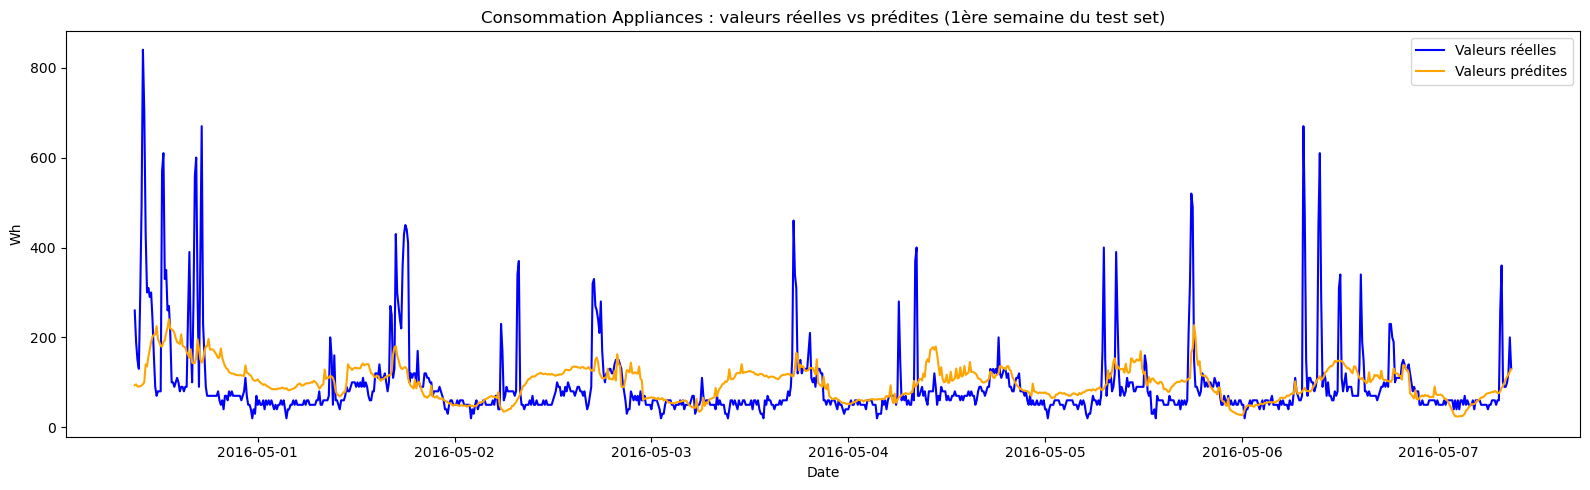

In [45]:
# Sélection de la première semaine du test set
first_week_idx = y_test.index[:7*24*6]  # 7 jours * 24h * 6 pas de 10min = 1008 points
y_true_week = y_test.loc[first_week_idx]
y_pred_week = y_pred_test[:len(y_true_week)]

plt.figure(figsize=(16, 5))
plt.plot(y_true_week.index, y_true_week.values, label='Valeurs réelles', color='blue')
plt.plot(y_true_week.index, y_pred_week, label='Valeurs prédites', color='orange')
plt.title("Consommation Appliances : valeurs réelles vs prédites (1ère semaine du test set)")
plt.xlabel("Date")
plt.ylabel("Wh")
plt.legend()
plt.tight_layout()
plt.show()

On comprends pourquoi la MAE et le RMSE sont si élevés et que le modèle ne parvient pas à capturer les pics de consommation en les sous estimant. 

#### ii) Impact de la normalisation

On va maintenant montrer que pour l'OLS classique, la **normalisation** des données n'a pas d'impact sur les performances.

**Point de vu pratique :**

In [46]:
# Test de l'impact de la normalisation sur OLS (LinearRegression) pour FS0
# Sans normalisation
res_no_scaling = run_model(LinearRegression(), fs='FS0', target='raw', X_scaled=False, y_scaled=False)
display_results(res_no_scaling)

# Avec normalisation
res_scaling = run_model(LinearRegression(), fs='FS0', target='raw', X_scaled=True, y_scaled=False)
display_results(res_scaling)

LinearRegression — FS0 — raw  (X_scaled=False, y_scaled=False)
 TRAIN  RMSE 95.75  MAE 54.36  R2 0.173
 TEST   RMSE 86.10  MAE 51.76  R2 0.095
LinearRegression — FS0 — raw  (X_scaled=True, y_scaled=False)
 TRAIN  RMSE 95.75  MAE 54.36  R2 0.173
 TEST   RMSE 86.10  MAE 51.76  R2 0.095


On a bien exactement les **même résultats** (RMSE, MAE, R²) **avec ou sans normalisation** des données.

**Point de vu théorique** :

On note $X\in\mathbb{R}^{n\times p}$ la matrice des features, $y\in\mathbb{R}^n$ le vecteur cible, et $\mathbf{1}\in\mathbb{R}^n$ le vecteur de 1. L’OLS avec intercept minimise :
$$
(\hat\beta_0,\hat\beta)
= \arg\min_{\beta_0,\beta}\,\big\|y - X\beta - \beta_0\,\mathbf{1}\big\|^2.
$$
La solution s’écrit en concaténant les colonnes :

$$
\widetilde X = [\mathbf{1}\;\;X],
\qquad
\begin{pmatrix}\hat\beta_0\\\hat\beta\end{pmatrix}
= (\widetilde X^\top \widetilde X)^{-1}\,\widetilde X^\top y.
$$

Soient 
$$
\mu = \tfrac1n\,X^\top\mathbf{1},
\qquad
D = \mathrm{diag}(\sigma_1,\dots,\sigma_p),
$$
où $\mu_j$ et $\sigma_j$ sont respectivement la moyenne et l’écart-type de la colonne $X_j$. On définit la version centrée et réduite :
$$
X_{\text{norm}}
= (X - \mathbf{1}\,\mu^\top)\,D^{-1},
\quad
\widetilde X_{\text{norm}} = [\mathbf{1}\;\;X_{\text{norm}}].
$$

On montre alors que, pour la même cible $y$,
$$
\hat\beta_{\text{norm}}
= D\,\hat\beta,
\quad
\hat\beta_{0,\text{norm}}
= \hat\beta_0 \;-\;\mu^\top\hat\beta,
$$
et surtout que les **prédictions** coïncident :  
pour tout $x$ (ligne de $X$),  
$$
\hat y_{\text{norm}} = \hat\beta_{0,\text{norm}} + x_{\text{norm}}^\top \hat\beta_{\text{norm}}
= \hat\beta_0 + x^\top \hat\beta = \hat y
$$

**Conclusion** : centrer et réduire les variables change l’échelle des coefficients et déplace l’intercept, mais **ne modifie pas** ni la droite de régression ni les prédictions de l’OLS classique.


#### iii) Impact de la transformation log

On va maintenant tester l'impact de la **transformation log** de la cible `Appliances` sur les performances du modèle OLS.

Pour cela, on regarde les résultats (toujours sur le **feature set 0**) avec et sans transformation log.

In [47]:
# Sans transformation log (cible brute)
res_raw = run_model(LinearRegression(), fs='FS0', target='raw')
display_results(res_raw)

# Avec transformation log (cible log1p)
res_log = run_model(LinearRegression(), fs='FS0', target='log')
display_results(res_log)

LinearRegression — FS0 — raw  (X_scaled=True, y_scaled=False)
 TRAIN  RMSE 95.75  MAE 54.36  R2 0.173
 TEST   RMSE 86.10  MAE 51.76  R2 0.095
LinearRegression — FS0 — log  (X_scaled=True, y_scaled=False)
 TRAIN  RMSE 99.02  MAE 46.03  R2 0.115
 TEST   RMSE 85.62  MAE 42.21  R2 0.105


**MAE**: 
- forte amélioration (–15 % en train, –18 % en test)
- le `log1p` atténue l’influence des gros pics et rapproche la plupart des valeurs de la zone centrale. 
- Donc en moyenne, les prédictions sont plus proches des valeurs réelles.

**RMSE** : 
- Pas de changement significatif

**Comparaison MAE vs RMSE**  
   - La **MAE** (linéaire) bénéficie davantage de la compression des valeurs extrêmes en log-espace
   - La **RMSE** (quadratique) reste presque inchangée car les quelques très gros résidus continuent de croître quadratiquement après retour en Wh.

**R²** : (On pense que)
- La transformation log **réduit l’influence des outliers** en apprentissage (biais ↑), entraînant une baisse du R² train.  
- Mais, elle **améliore la robustesse et la généralisation** (variance ↓), ce qui se traduit par une légère hausse du R² test.
- C'est une belle démonstration du **compromis biais-variance**. 

Bien qu'un impact soit visible, les erreurs restent très élevés. Cette transformation à elle seule ne suffit pas à améliorer les performances du modèle. 

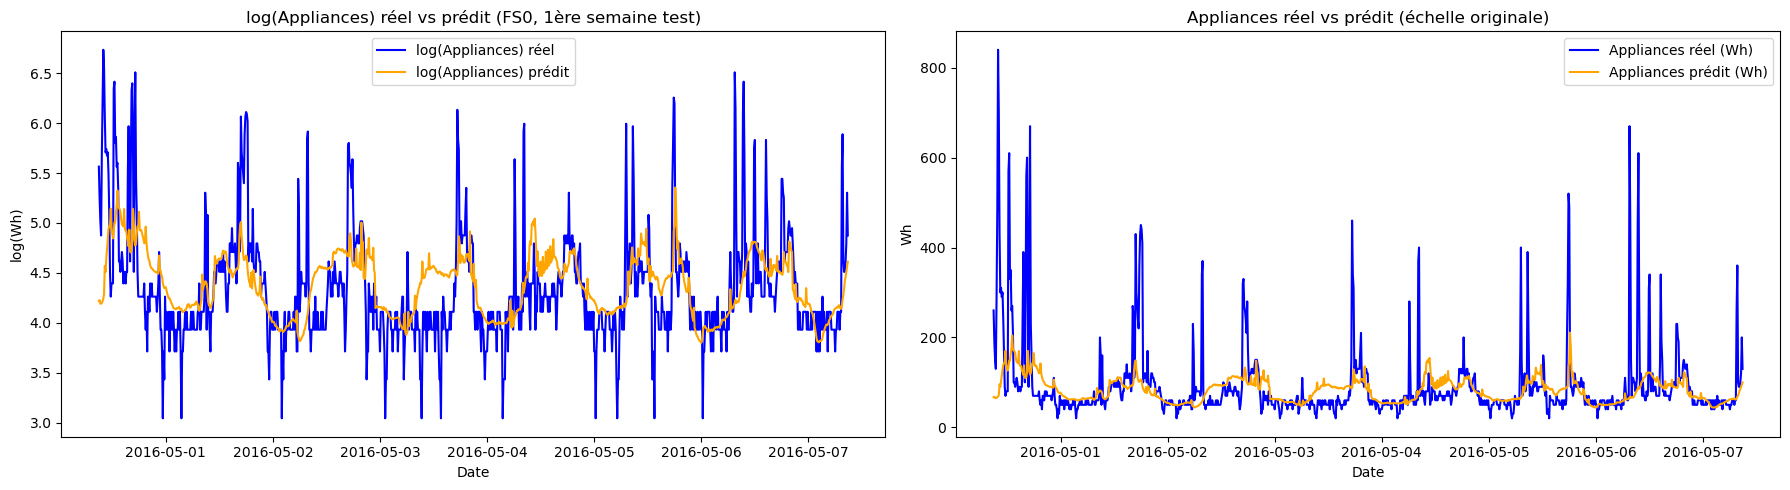

In [48]:
# Affichage des valeurs prédites en log pour la première semaine du test set

y_pred_log = np.log1p(res_log['y_pred_test'][:len(first_week_idx)])

# Récupérer les valeurs prédites dans l'échelle d'origine (Wh)
y_pred_orig = res_log['y_pred_test'][:len(first_week_idx)]
y_true_orig = y_test.loc[first_week_idx]

plt.figure(figsize=(18, 5))

# Plot log1p(Appliances)
plt.subplot(1, 2, 1)
plt.plot(first_week_idx, y_test_log.loc[first_week_idx], label='log(Appliances) réel', color='blue')
plt.plot(first_week_idx, y_pred_log, label='log(Appliances) prédit', color='orange')
plt.title("log(Appliances) réel vs prédit (FS0, 1ère semaine test)")
plt.xlabel("Date")
plt.ylabel("log(Wh)")
plt.legend()

# Plot valeurs dans l'échelle d'origine
plt.subplot(1, 2, 2)
plt.plot(first_week_idx, y_true_orig, label='Appliances réel (Wh)', color='blue')
plt.plot(first_week_idx, y_pred_orig, label='Appliances prédit (Wh)', color='orange')
plt.title("Appliances réel vs prédit (échelle originale)")
plt.xlabel("Date")
plt.ylabel("Wh")
plt.legend()

plt.tight_layout()
plt.show()

Lorsqu'on repasse à l'échelle d'origine, on a quand même du mal à modéliser les pics de consommation.

#### iv) Impact des features-sets

On va maintenant analyser la contribution des différents **features-sets** sur les performances du modèle OLS.

Affichons directement les résultats des 5 features-sets sur le modèle OLS.

In [49]:

# Tableau récapitulatif des scores sur le test set pour chaque feature set
scores = []
for fs in feature_sets.keys():
    target = 'raw' if fs != 'FS3_log' else 'log'
    result = run_model(LinearRegression(), fs=fs, target=target)
    scores.append({
        'Feature set': fs,
        'RMSE': result['test_RMSE'],
        'MAE': result['test_MAE'],
        'R2': result['test_R2']
    })

OLS_perfs = pd.DataFrame(scores)
OLS_perfs

,Feature set,RMSE,MAE,R2
0,FS0,86.097191,51.756496,0.095048
1,FS1,85.795362,52.095894,0.101381
2,FS2,88.679163,55.479304,0.039956
3,FS3,56.100527,26.811540,0.615778
4,FS3_log,58.365506,23.962116,0.584127


**Analyse des résultats** :

**FS1 (ajout de `hour`, `dayofweek`, `occupancy`)** :  
- Léger gain de R² (+0.006) et RMSE quasi inchangé, montrant que la structure temporelle ajoute un signal faible mais exploitable.
- Assez décevant, on s'attendait à un gain plus important.

**FS2 (remplacement des variables de température/humidité par PCA)** :  
- Baisse significative des performances (RMSE ↑, R² ↓)
- Ca montre que la **multicolinéarité** n'affecte pas vraiment la prédiction 
- Et que la perte d'information due à **l'ACP** est plus importante que le gain de stabilité (même si on a gardé 90% de la variance).

**FS3 (ajout de lags et statistiques glissantes)** :  
- Amélioration spectaculaire (RMSE –30 Wh, MAE –25 Wh, R^2 ×6.5)
- montre l’intérêt majeur de la mémoire temporelle pour modéliser les pics de consommation.

**FS3_log (même que FS3 avec cible log-transformée)** :  
- La transformation log améliore la MAE (-3 Wh par rapport à FS3) 
- Mais, la RMSE augmente légerement (+2 Wh) car les outliers restent influents.  
- On perd en R² (-0.02) car la transformation log réduit l’influence des outliers en apprentissage (biais ↑), entraînant une baisse du R² train
- Ces comportements montrent ce que l'on avait déjà observé sur l'impact du log. 


#### v) Test vs Train

On va maintenant analyser les performances du modèle OLS sur le **train set** et le **test set** pour chaque features-set afin de voir si il y a du **sur-apprentissage** ou pas.

In [50]:
# Affiche les performances train/test pour chaque feature set dans un DataFrame
perf = []
for fs in feature_sets.keys():
    target = 'raw' if fs != 'FS3_log' else 'log'
    res = run_model(LinearRegression(), fs=fs, target=target)
    perf.append({
        'Feature set': fs,
        'Train RMSE': res['train_RMSE'],
        'Test RMSE': res['test_RMSE'],
        'Train MAE': res['train_MAE'],
        'Test MAE': res['test_MAE'],
        'Train R2': res['train_R2'],
        'Test R2': res['test_R2'],
    })

display(pd.DataFrame(perf))

,Feature set,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,FS0,95.751151,86.097191,54.361163,51.756496,0.172532,0.095048
1,FS1,95.519252,85.795362,54.349168,52.095894,0.176536,0.101381
2,FS2,99.593122,88.679163,56.595965,55.479304,0.104797,0.039956
3,FS3,62.890742,56.100527,30.941871,26.811540,0.643026,0.615778
4,FS3_log,66.163046,58.365506,28.124080,23.962116,0.604912,0.584127


- **Erreurs plus faibles en test**  
  - Pour tous les feature sets, le RMSE et la MAE sont environ **10–12 %** et **5–15 %** inférieurs sur le jeu de test par rapport au train. 
  - Il n'y a donc **pas de surapprentissage**
  - Mais une **variance intrinsèque** plus faible dans le sous-ensemble de test qui fait qu'on prédit "moins mal" en test (cf en dessous).

- **Perte de pouvoir explicatif**    
  - Un écart **faible** de R² (≈ 0.02–0.03) signale une **bonne généralisation**, la structure apprise se transpose bien.  
  - Un écart **plus marqué** de R² (≈ 0.06–0.08) traduit une **sensibilité** du modèle aux données d’entraînement une sous-adaptation aux nouvelles dynamiques.

- **Biais vs variance**  
  - Les faibles écarts de R² et l’erreur test diminuée indiquent un modèle à **biais élevé** (biais constant entre train/test) mais à **variance contrôlée**.  
  - Lorsque l’écart R² est plus grand, le modèle a appris des détails spécifiques au train (variance ↑) ou n’a pas capturé certains cycles (biais ↑).

**Conclusion** :  Cet écart train vs test est fortement dépendant du feature set choisi 
- Les jeux sans mémoire temporelle (FS0–FS2) présentent les plus grands ΔR² (≈ 0.06–0.08), montrant leur difficulté à généraliser.  
- Les jeux intégrant lags et rolling stats (FS3, FS3_log) réduisent ce gap à ≈ 0.02–0.03, soulignant l’effet stabilisant de ces features sur la variabilité hors échantillon.  

In [51]:
# STD de la consommation `Appliances` sur les jeux train et test
std_train = y_train.std()
std_test  = y_test.std()

print(f"Ecart type de l'Appliances (train) : {std_train:.2f}")
print(f"Ecart type de l'Appliances (test)  : {std_test:.2f}")

Ecart type de l'Appliances (train) : 105.26
Ecart type de l'Appliances (test)  : 90.52


La chute de MSE/RMSE entre train et test s'explique par **la variance intrinsèque** plus faible du test, pas par un **surapprentissage**.

En effet : 
- pour un R² pratiquement constant, le RMSE et la MAE sont plus vraiment faibles en test qu’en train. 
- La variance/écart-type de la cible est plus faible sur le test que sur le train (≈ 105 Wh vs 90 Wh).
- C'est ce qui nous laisse à penser que le modèle n'est pas sur-appris, mais qu'il est trop simple pour capturer les variations de la cible.

#### Conclusion et transition

**On a vu :**

- **Baseline (FS0, données brutes)**  
  - Sur les données brutes, le modèle OLS classique ne parvient pas à capturer la variabilité de la consommation.
  - Mais sur le `FS3` (ajout de lags et rolling stats) on a des performances très correct pour un modèle linéaire simple (RMSE ≈ 56 Wh, MAE ≈ 26 Wh, R² ≈ 0.61). 

- **Normalisation**  
  Centrage/réduction des X n’a **aucun impact** sur les prédictions de l’OLS (RMSE/MAE identiques), comme démontré théoriquement.

- **Transformation log de la cible**  
  Le `log1p(Appliances)` réduit la MAE de ~15–18 % (mieux gérer les outliers) sans changer significativement la RMSE, au prix d’un léger recul du R² train et d’une petite hausse du R² test.

- **Impact des feature-sets**  
  - FS1 (ajout de `hour`, `dayofweek`, `occupancy`) : gain marginal.  
  - FS2 (PCA sur T/RH) : perte de performance (trop d’information perdue).  
  - FS3 (lags + rolling stats) : bond spectaculaire (R² ≈ 0.62) et RMSE/MAE divisés par ~1/3.  
  - FS3_log : légère amélioration de la MAE mais RMSE en légère hausse et R² en retrait par rapport à FS3.

- **Train vs Test**  
  - RMSE/MAE plus faibles en test (–10 % RMSE, –5 % MAE) expliqués par une variance intrinsèquement plus faible dans le split test (σ_train ≈ 105 Wh vs σ_test ≈ 90 Wh), sans forte chute de R².  
  - FS3 et FS3_log affichent les plus petits écarts train–test (ΔR² ≈ 0.02–0.03), signe d’une meilleure généralisation grâce aux features temporelles.

>**A suivre :**
>
>Même si ce modèle ne souffre pas **d'overfitting** nous allons quand même passer au modèle **Ridge** et voir si il y a tout de même un avantage à utiliser la **régularisation** L2.

### **b) Ridge**


On va maintenant tester le modèle de **régularisation Ridge** sur les 4 features-sets pour un ensemble de paramètres **alpha**. 

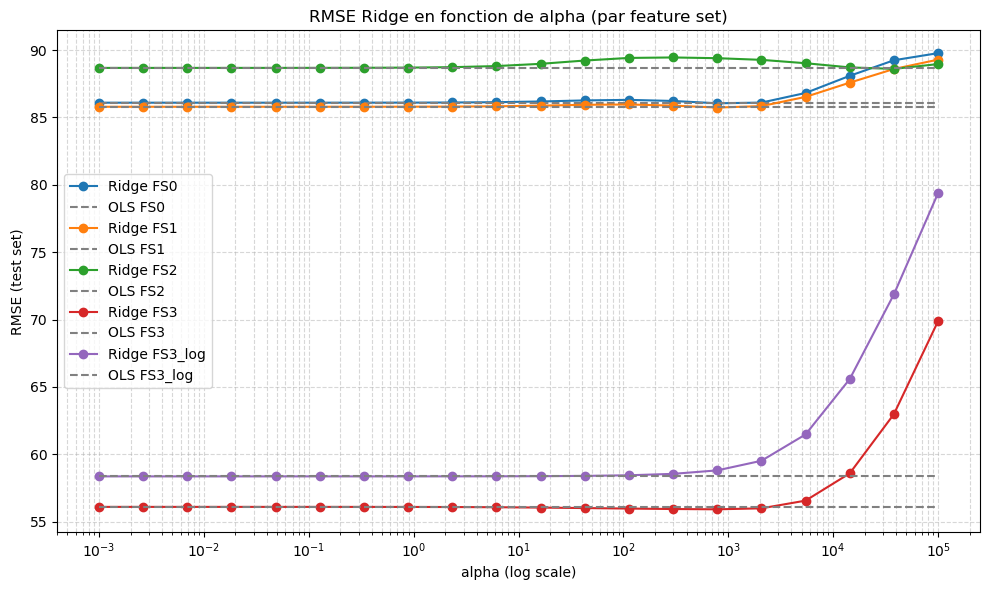

In [92]:
from sklearn.linear_model import Ridge

alphas = np.logspace(-3, 5, 20)
fs_list = list(feature_sets.keys())
rmse_by_fs = {fs: [] for fs in fs_list}
ols_rmse = {}

for fs in fs_list:
    target = 'raw' if fs != 'FS3_log' else 'log'
    # OLS (alpha=0) pour référence
    ols_res = run_model(LinearRegression(), fs=fs, target=target)
    ols_rmse[fs] = ols_res['test_RMSE']
    # Ridge pour chaque alpha
    for alpha in alphas:
        res = run_model(Ridge(alpha=alpha), fs=fs, target=target)
        rmse_by_fs[fs].append(res['test_RMSE'])

plt.figure(figsize=(10, 6))
for fs in fs_list:
    plt.plot(alphas, rmse_by_fs[fs], marker='o', label=f'Ridge {fs}')
    plt.hlines(ols_rmse[fs], alphas[0], alphas[-1], colors='gray', linestyles='dashed', label=f'OLS {fs}')
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('RMSE (test set)')
plt.title('RMSE Ridge en fonction de alpha (par feature set)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Ci dessus, on a tracé les performances (RMSE) pour chaque features-set pour les **20 valeurs de alpha** entre 0 et 5. 

On voit que le modèle **Ridge** n'est pas du tout pertinent dans notre cas. 

Comme prévu, en **l'abscence d'overfitting**, le modèle Ridge ne fait pas mieux que l'OLS classique.

Pour les valeurs de alpha qui dépassent 3, les performances se dégradent totalement. 

**Conclusion :**
- Le modèle Ridge fait au mieux pareil que l'OLS classique, mais ne fait pas mieux.
- Ceci est dû à l'absence d'overfitting sur le modèle OLS classique.
- On va donc passer au modèle **Lasso** pour sa capacité à faire de la **sélection de variables** et voir si il y a un gain de performance.

### **c) Lasso**

Lors de l'analyse descriptive, on a vu qu'il y avait beaucoup de **multicolinéarité** entre certaines variables. 

Lors du **feature engineering**, on a alors appliqué une **ACP** sur les variables de température et d'humidité pour réduire cette multicolinéarité.

Mais, on a aussi ajouté des **lags** et des **rolling stats** qui sont surement très corrélés entre eux.

Aussi, lors de la partie sur **l'OLS**, nous n'avons pas analyser les coefficients du modèle. 

Il y en a peut être qui sont peu utiles et qui pourraient être **supprimées**.

C'est pour ces raisons que nous allons maintenant tester le modèle **Lasso** qui va nous permettre de faire de la **sélection de variables** et de réduire la **multicolinéarité**.

#### i) Multicolinéarité et variables inutiles

On commence par chercher la **multicolinéarité** entre les variables explicatives du **feature set 3** en traçant la **matrice de corrélation**.

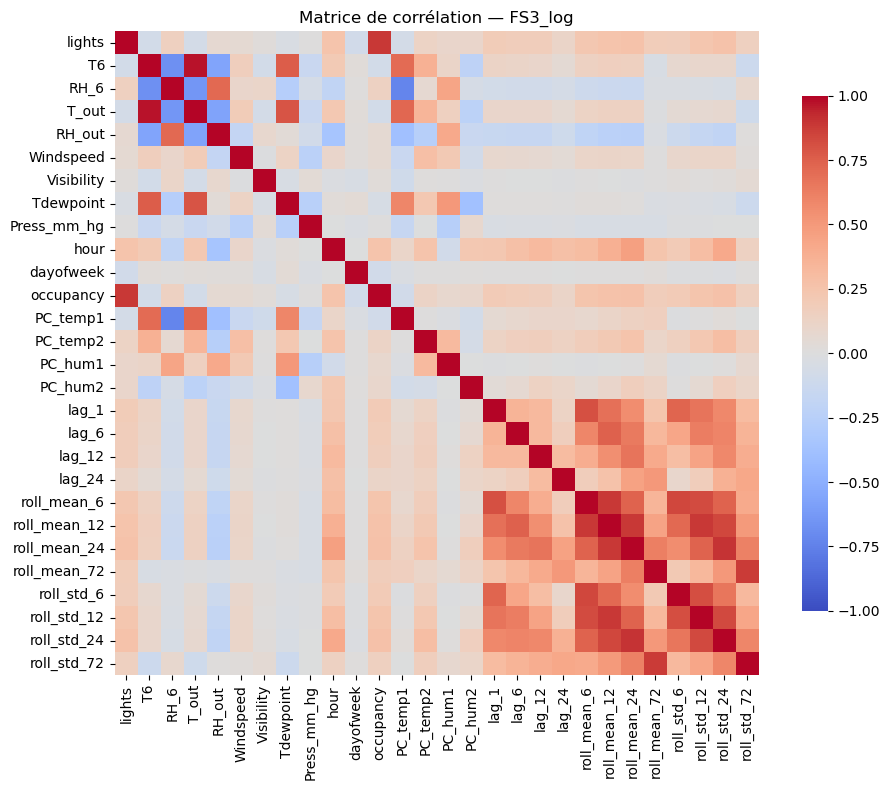

In [53]:

cols = feature_sets["FS3"].copy()

# Extraction du sous-dataframe
corr_df = df[cols]
# Calcul de la matrice de corrélation
corr = corr_df.corr()
# Affichage
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True, cbar_kws={'shrink': 0.8})
plt.title(f"Matrice de corrélation — {fs}")
plt.tight_layout()
plt.show()

Comme on s'y attendait, il y a beaucoup de **corrélations** entre les **lags** et les **rolling stats**.

Aussi, on remarque que les variables `T6`, `RH_6`, `T_out`, `RH_out` sont très corrélées entre elles.

Ce qui est évident puisque ce sont des variables de température et d'humidité extérieures.

> - Comme on l'a vu précédemment, la multicolinéarité n'affecte pas tant les performances du modèle OLS.
> - Mais, elle peut affecter la stabilité des coefficients et leur interprétation.
> - Et surtout, pour d'autres modèles elle aura un impact plus important. 

Voyons si certains coefficients du modèle **OLS** étaient peu utiles.

LinearRegression — FS3 — raw  (X_scaled=True, y_scaled=False)
 TRAIN  RMSE 62.89  MAE 30.94  R2 0.643
 TEST   RMSE 56.10  MAE 26.81  R2 0.616

Coefficients du modèle OLS (FS3) :


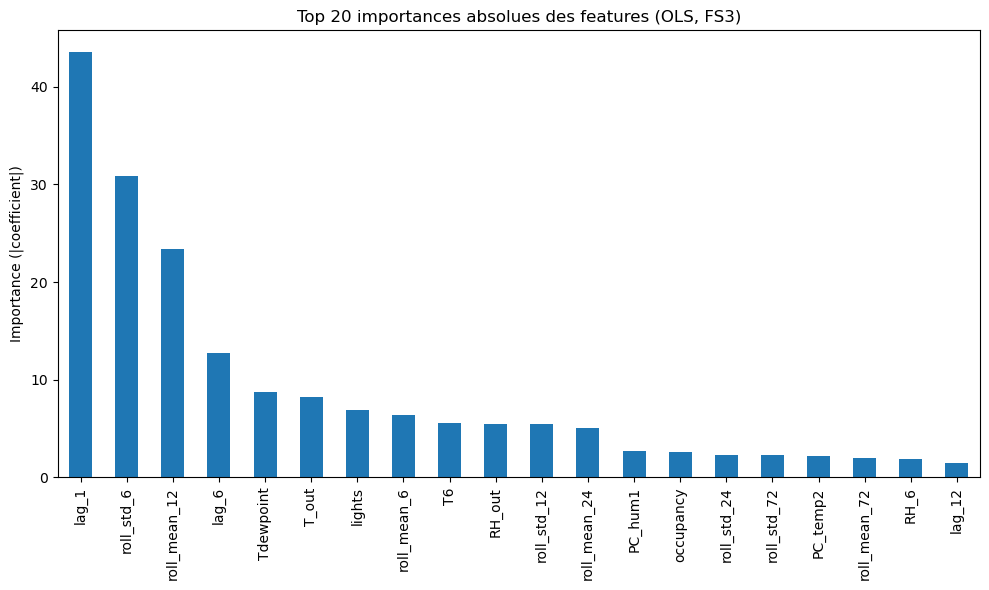

In [54]:
# Utilisation de run_model pour OLS sur FS3 et affichage des métriques
res_ols_fs3 = run_model(LinearRegression(), fs='FS3', target='raw')
display_results(res_ols_fs3)

# Affichage des coefficients triés par importance
coefs = pd.Series(res_ols_fs3['model'].coef_, index=feature_sets['FS3'])
coefs = coefs.sort_values(key=np.abs, ascending=False)
print("\nCoefficients du modèle OLS (FS3) :")
# Affichage des coefficients triés par importance absolue (feature importance)
plt.figure(figsize=(10, 6))
coefs_abs = coefs.abs()
coefs_abs.head(20).plot(kind='bar')
plt.title("Top 20 importances absolues des features (OLS, FS3)")
plt.ylabel("Importance (|coefficient|)")
plt.tight_layout()
plt.show()


Il semble que certaines variables soient plus importantes que d'autres. On peut alors penser que le modèle **Lasso** va en supprimer certaines.

#### **ii) Hyperparamètres et validation croisée**

On va implémenter une **validation croisée temporelle** pour trouver le **meilleur hyperparamètre** pour le modèle Lasso.

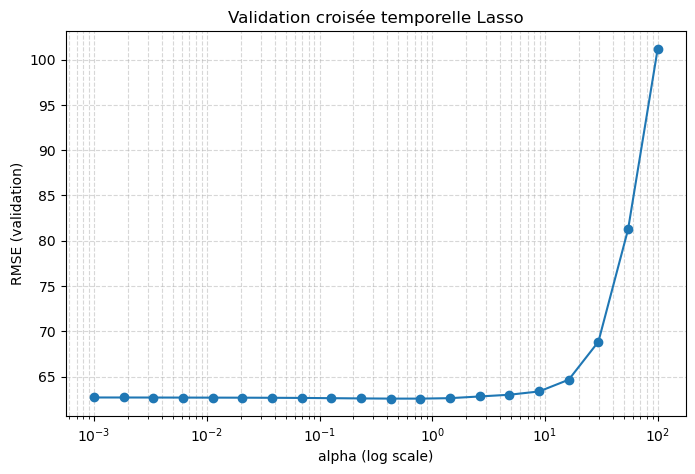

Meilleur alpha (CV): 0.7848 — RMSE: 62.56


In [55]:
from sklearn.linear_model import Lasso

# On choisit le feature set le plus riche (FS3 ou FS3_log)
fs = 'FS3'
target = 'raw'
alphas = np.logspace(-3, 2, 20)  # de 0.001 à 100

X = get_X(fs, 'train', scaled=True)
y = get_y(target, 'train', scaled=False)

tscv = TimeSeriesSplit(n_splits=5)
mean_rmse = []

for alpha in alphas:
    rmses = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        model = Lasso(alpha=alpha, max_iter=10000)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    mean_rmse.append(np.mean(rmses))

# Affichage du RMSE moyen en fonction de alpha
plt.figure(figsize=(8,5))
plt.plot(alphas, mean_rmse, marker='o')
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('RMSE (validation)')
plt.title('Validation croisée temporelle Lasso')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# Meilleur alpha
best_alpha = alphas[np.argmin(mean_rmse)]
print(f"Meilleur alpha (CV): {best_alpha:.4f} — RMSE: {min(mean_rmse):.2f}")

A l'image du modèle **Ridge**, on ne constate **aucune amélioration** des performances du modèle Lasso par rapport à l'OLS classique. Et à partir d'une certaine valeur de alpha, les performances se dégradent totalement.

#### iii) Coefficients du modèle Lasso

On va maintenant vérifier les hypothèses que nous avons faites. 

In [56]:
# Entraînement du Lasso avec le meilleur alpha trouvé
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(X, y)

# Nombre de coefficients mis à 0
n_zeros = np.sum(lasso.coef_ == 0)
print(f"Nombre de coefficients mis à 0 par Lasso (alpha={best_alpha:.4f}) : {n_zeros} / {X.shape[1]}")

Nombre de coefficients mis à 0 par Lasso (alpha=0.7848) : 16 / 28


Quasiment la moitié des variables ont été supprimées par le modèle **Lasso**. C'est ce qu'on attendait. 

Lasso — FS3 — raw  (X_scaled=True, y_scaled=False)
 TRAIN  RMSE 63.03  MAE 30.70  R2 0.641
 TEST   RMSE 55.96  MAE 26.26  R2 0.618


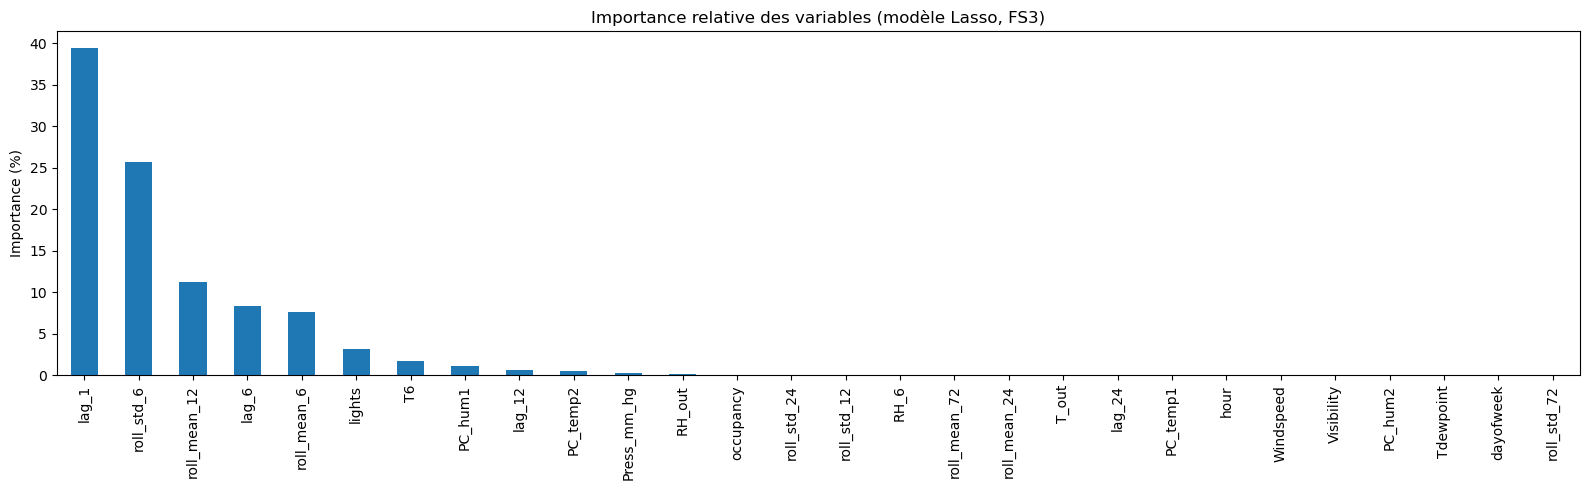

In [57]:
# affichage des coefficients du lasso 

# Utilisation de run_model pour obtenir directement les métriques sur le test set
res_lasso = run_model(lasso, fs='FS3', target='raw', X_scaled=True, y_scaled=False)
display_results(res_lasso)

# Affichage de l'importance des coefficients
coefs = pd.Series(lasso.coef_, index=X_train[feature_sets['FS3']].columns)
abs_coefs = coefs.abs()
importance = 100 * abs_coefs / abs_coefs.sum()
importance.sort_values(ascending=False).plot(kind='bar', figsize=(16, 5))
plt.title("Importance relative des variables (modèle Lasso, FS3)")
plt.ylabel("Importance (%)")
plt.tight_layout()
plt.show()

**Variables Extérieurs** :
- Comme on l'avait prédit, les variables `T_out`, `RH_out`, `T6`, `RH_6` ne sont pas toutes gardées.
- Comme elles sont très corrélées entre elles, le modèle Lasso en **garde 1 en température et 1 en humidité**.
- Ca montre la force de la **régularisation** L1. 

**Lags et rolling stats** :
- On avait comme hypothèse que les lags et rolling stats étaient très corrélés entre eux et que le Lasso allait en supprimer.
- C'est ce qu'il fait, il garde : 3 `lags` sur 4, 2 `rolling stats` sur 4 et 1 `rolling std` sur 4.
- On a donc une **réduction de dimension** de 50% sur ces variables.
- On a donc bien réduit la **multicolinéarité** entre ces variables en gardant automatiquement **les plus importantes**.

**Occupancy vs lights**:
- On avait ajouté la variable `occupancy` qui était simplement 1 si `lights` > 0 et 0 sinon.
- C'est évidemment très corrélé avec la variable `lights` et peu pertinent d'avoir les deux. 
- Le modèle Lasso en garde une seule, ce qui encore une fois est très logique. 

#### **Conlcusion**:

- Le modèle **Lasso** n'a pas amélioré les performances du modèle OLS classique.
- Mais, à performance égale, il a permis de réduire la **multicolinéarité** entre les variables et de faire de la **sélection de variables**.
- Son utilisation est très pertinente dans notre cas puisqu'après le **feature engineering**, on a avait beaucoup de variables corrélées entre elles.*
- De plus, le modèle à mis supprimer les variables de **la même manière que nous l'aurions fait manuellement**, ce qui montre la pertinence de la **régularisation** L1.
- On a plus que **16 variables au lieu de 28**, ce qui est excellent pour **l'interprétation du modèle**.

Ce modèle **L1** est donc très intéressant, mais il ne fait pas mieux que l'OLS classique.

Cela s'explique par le fait que les modèles linéaires ne suffisent pas à capturer la **non-linéarité** des données qui est forcément présente. 

C'est pourquoi, nous allons passer à la **régression par noyau** qui est un modèle non-linéaire.

> **Conclusion générale sur les modèles linéaires**:
>
> - Le modèle OLS classique est très simple et ne parvient pas à capturer la variabilité de la consommation.
> - La normalisation des données n'a pas d'impact sur les performances du modèle OLS classique.
> - La transformation log de la cible améliore la MAE, mais pas la RMSE.
> - Le modèle Ridge ne fait pas mieux que l'OLS classique.
> - Le modèle Lasso permet de réduire la multicolinéarité entre les variables et de faire de la sélection de variables.
> - Mais, il ne fait pas mieux que l'OLS classique.
> - On a maintenant une **baseline de performances** (RMSE ≈ 56 Wh, MAE ≈ 26 Wh, R² ≈ 0.61) sur le feature set 3 (lags + rolling stats).
> - Les modèles linéaires ne suffisent pas à capturer la **non-linéarité** des données.
> - On va donc passer à la **régression par noyau** qui est un modèle non-linéaire.

## **6.2 Régression à noyau**



Dans cette partie, nous allons implémenter la **régression à noyau**. 

Nous allons aborder les points suivants :
- L'importance de la **normalisation** et de la **transformation log** de la cible
- Le choix du **noyau** 
- L'impact et le choix des **hyperparamètres** par **validation croisée temporelle**
- On testera la **régularisation** L2 sur ce modèle en comparant aux modèles linéaires. 
- Et on finira par comparer les performances du modèle contre celles des **modèles linéaires**.

#### **i) Normalisation et transformation log**

La régression à noyaux (par exemple avec un noyau RBF ou polynomial) repose sur le calcul de **distances** (ou produits scalaires) entre vecteurs d’entrée :  
$$
K(x, x') = \exp\bigl(-\gamma \|x - x'\|^2\bigr)\quad\text{ou}\quad K(x, x') = (x^\top x' + c)^d.
$$

Il semble donc évident que la **normalisation** des données est nécessaire pour éviter que certaines variables dominent le calcul de la distance.

Sinon, on a des **echelles hétérogènes** entre les variables qui faussent le calcul.

Par exemple, si une variable a des valeurs de l’ordre de 10⁵ et une autre de l’ordre de 10⁻², la distance euclidienne sera dominée par la première, rendant la contribution des autres négligeable dans le noyau.

Vérifions cela en pratique : 


In [58]:
from sklearn.kernel_ridge import KernelRidge

set = 'FS0'

# Régression à noyau RBF sur données normalisées
res_rbf_scaled = run_model(
    KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1),
    fs=set,
    target='raw',
    X_scaled=True,
    y_scaled=True
)
display_results(res_rbf_scaled)

# Régression à noyau RBF sur données non normalisées
res_rbf_nonscaled = run_model(
    KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1),
    fs=set,
    target='raw',
    X_scaled=False,
    y_scaled=False
)
display_results(res_rbf_nonscaled)

KernelRidge — FS0 — raw  (X_scaled=True, y_scaled=True)
 TRAIN  RMSE 68.22  MAE 35.39  R2 0.580
 TEST   RMSE 88.79  MAE 51.33  R2 0.037
KernelRidge — FS0 — raw  (X_scaled=False, y_scaled=False)
 TRAIN  RMSE 58.90  MAE 32.75  R2 0.687
 TEST   RMSE 131.94  MAE 95.99  R2 -1.125


**Avec normalisation**:
- Le modèle reste raisonnablement stable hors échantillon (R² proche de 0), sans signe de sur-apprentissage excessif.

**Sans normalisation**
- Forte chute de R² et explosion de l’erreur en test : **sur-apprentissage** et **instabilité numérique**.

**Interprétation** :  
La normalisation est **indispensable** en régression à noyaux. Sans **centrage/réduction**, les distances utilisées par le noyau sont **dominées** par les variables aux grandes échelles, conduisant à un ajustement artificiellement bon sur le train mais inadapté sur le test. 

> A partir de maintenant, on va donc toujours traiter les données **normalisées**

En ce qui concerne la **transformation log** de la cible, on va faire le même test que pour le modèle OLS.

In [60]:
res_rbf_raw = run_model(
    KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1),
    fs='FS0',
    target='raw',
    X_scaled=True,
    y_scaled=True
)

res_rbf_log = run_model(
    KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1),
    fs='FS0',
    target='log',
    X_scaled=True,
    y_scaled=True
)

In [61]:
display_results(res_rbf_raw)
display_results(res_rbf_log)

KernelRidge — FS0 — raw  (X_scaled=True, y_scaled=True)
 TRAIN  RMSE 68.22  MAE 35.39  R2 0.580
 TEST   RMSE 88.79  MAE 51.33  R2 0.037
KernelRidge — FS0 — log  (X_scaled=True, y_scaled=True)
 TRAIN  RMSE 75.70  MAE 32.34  R2 0.483
 TEST   RMSE 90.72  MAE 42.07  R2 -0.005


On a le même phénomène que pour le modèle **OLS**.

**La log-transformation est un compromis :**
- elle améliore la robustesse aux outliers (MAE ↓) 
- mais pénalise la capture des plus fortes consommations (RMSE ↑, R² ↓). 
- En fonction de l'objectif, on peut choisir entre les deux.

#### **ii) Choix du noyau**

Parmi les options courantes (linéaire, polynomial, gaussien…), nous retenons ici le **noyau gaussien (RBF)** pour sa **flexibilité** :  
- il mesure la **similarité** entre deux observations $x$ et $x'$ via la formule $K(x, x') = \exp(-\gamma \|x - x'\|^2)$, qui décroît avec la distance euclidienne entre les points,  
- sa forme exponentielle permet de contrôler la portée de l’influence de chaque point d’entraînement via le paramètre $\gamma$ :  
  - un $\gamma$ **élevé** signifie que chaque point n’influence que ses voisins proches (puisque ca tend très vite vers 0), ce qui permet au modèle de s’adapter fortement aux données, **y compris au bruit** → **surapprentissage**,  
  - un $\gamma$ **faible** entraîne une influence plus étendue de chaque point, ce qui **lisse** davantage le modèle et favorise la **généralisation**, au risque de **sous-apprendre**,  
  - Nous illustrerons cela plus tard avec la validation croisée.
- le noyau RBF s’adapte naturellement à des relations non linéaires complexes, sans imposer de structure a priori sur les interactions entre variables.

Nous n'utilisons pas le **noyau polynomial**, car nous n’avons ici **aucune intuition sur le degré des interactions** à modéliser, ce qui le rendrait trop rigide et moins pertinent dans notre contexte.  

Nous aurions aussi pu considérer une **somme de noyaux RBF et cosinus** pour capturer manuellement les **composantes cycliques** identifiées lors de l'exploration temporelle.

*(Des tests avec d'autres noyaux ont été effectués mais ne sont pas présentés ici, afin de préserver la lisibilité et la concision.)*

#### **iii) Hyperparamètres et validation croisée**

Pour optimiser $\gamma$ de notre noyau gaussien, nous utilisons une validation croisée en **5 folds temporels** (TimeSeriesSplit) afin de préserver **l’ordre chronologique**.

Nous cherchons à minimiser la MSE moyenne, puis nous en déduisons le RMSE sur le train pour choisir la meilleure combinaison.

Nous **fixons** le paramètre de régularisation pour l’instant, et nous allons le tester plus tard.

Ici, on fait la validation croisée sur les différents **features-sets** pour voir si il y a de grosses différences entre les performances et pouvoir se concentrer sur les plus intéressants.

In [63]:
from sklearn.model_selection import GridSearchCV

# Paramètres
gammas = [1e-3, 1e-2, 1e-1, 1, 10]
tscv   = TimeSeriesSplit(n_splits=5)

# Stockage des résultats
cv_results = []

for fs in feature_sets.keys():
    # Préparer X et y (train, normalisés)
    X = get_X(fs, which='train', scaled=True)
    y = get_y('raw', which='train', scaled=True)
    
    # KernelRidge avec alpha fixé
    kr = KernelRidge(alpha=1.0, kernel='rbf')
    grid = GridSearchCV(
        kr,
        param_grid={'gamma': gammas},
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid.fit(X, y)
    
    best_gamma = grid.best_params_['gamma']
    cv_rmse    = np.sqrt(-grid.best_score_)
    
    cv_results.append({
        'Feature set': fs,
        'Best γ':      best_gamma,
        'CV RMSE':     cv_rmse
    })
    print(f"Feature set {fs} : meilleur γ = {best_gamma:.4f}, CV RMSE = {cv_rmse:.2f}")

# Affichage récapitulatif
pd.DataFrame(cv_results)

KeyboardInterrupt: 


	| Feature set | Best γ  | CV RMSE   |
	|:-----------:|:-------:|:---------:|
	| FS0         | 0.001   | 0.936     |
	| FS1         | 0.001   | 0.935     |
	| FS2         | 0.001   | 0.963     |
	| FS3         | 0.010   | 0.588     |
	| FS3_log     | 0.010   | 0.611     |

*(On les affiche ici puisque la cellule est trop longue à exécuter)*


On voit que les **features-sets 3 et 3_log** sont presque **2 fois meilleurs** pour la RMSE moyenne que les autres. 

On va donc se concentrer sur le **feature set 3** pour la suite.

Maintenant, même si on a déjà fait une validation croisée, on va se concentrer sur le choix du paramètre $\gamma$ pour le **feature set 3** en regardant la **performance moyenne** et **la dispersion**.

In [67]:
gammas = [1e-4, 1e-3, 1e-2, 1e-1]
tscv   = TimeSeriesSplit(n_splits=5)
# Préparation des données pour FS3 (normalisées)
X = get_X('FS3', which='train', scaled=True)
y = get_y('raw', which='train', scaled=True)

scoring = {
    'neg_MAE': 'neg_mean_absolute_error',
    'neg_MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Kernel Ridge avec recherche sur gamma
kr = KernelRidge(alpha=1.0, kernel='rbf')
grid = GridSearchCV(
    kr,
    param_grid={'gamma': gammas},
    cv=tscv,
    scoring=scoring,
    refit='neg_MAE',  # Refit sur la meilleure valeur de gamma selon MAE
    return_train_score=True,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KernelRidge(alpha=1.0, kernel='rbf'), n_jobs=-1,
             param_grid={'gamma': [0.0001, 0.001, 0.01, 0.1]}, refit='neg_MAE',
             return_train_score=True,
             scoring={'R2': 'r2', 'neg_MAE': 'neg_mean_absolute_error',
                      'neg_MSE': 'neg_mean_squared_error'})

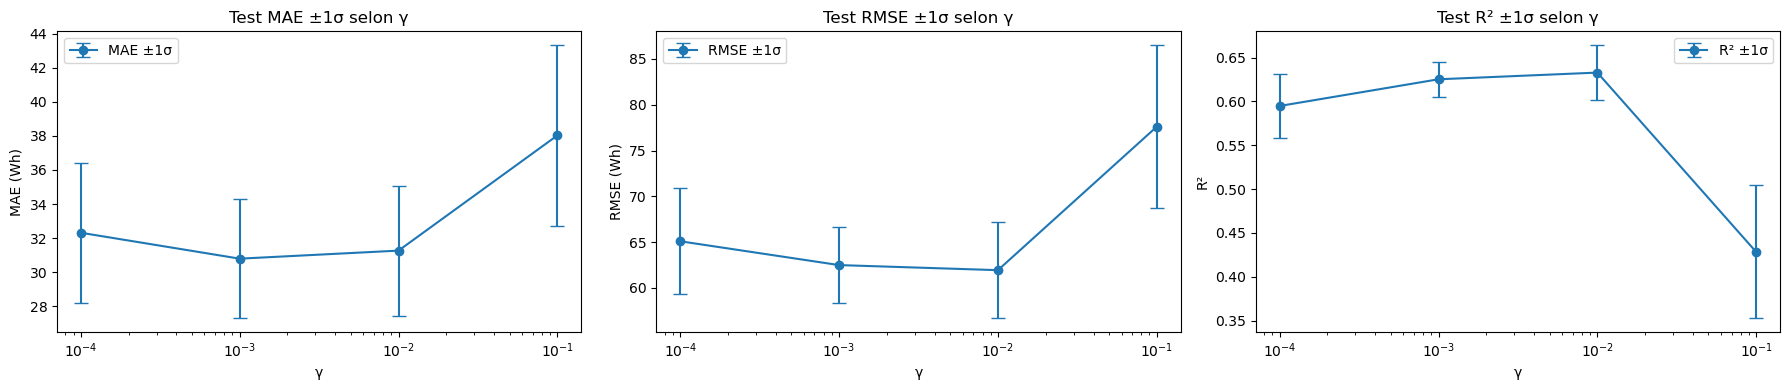

In [81]:
res = grid.cv_results_

gammas = np.array(res['param_gamma'], dtype=float)
mae_mean_scaled = -res['mean_test_neg_MAE']
mae_std_scaled  =  res['std_test_neg_MAE']
mse_mean_scaled = -res['mean_test_neg_MSE']
mse_std_scaled  =  res['std_test_neg_MSE']
r2_mean         =  res['mean_test_R2']
r2_std          =  res['std_test_R2']

rmse_mean_scaled = np.sqrt(mse_mean_scaled)
rmse_std_scaled  = mse_std_scaled / (2 * rmse_mean_scaled)

sigma_y = y_scaler.scale_[0]
mae_mean_wh  = mae_mean_scaled  * sigma_y
mae_std_wh   = mae_std_scaled   * sigma_y
rmse_mean_wh = rmse_mean_scaled * sigma_y
rmse_std_wh  = rmse_std_scaled  * sigma_y

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# MAE
axes[0].errorbar(
    gammas, mae_mean_wh, yerr=mae_std_wh,
    fmt='o-', capsize=5, label='MAE ±1σ'
)
axes[0].set_xscale('log')
axes[0].set_xlabel('γ')
axes[0].set_ylabel('MAE (Wh)')
axes[0].set_title('Test MAE ±1σ selon γ')
axes[0].legend()

# RMSE
axes[1].errorbar(
    gammas, rmse_mean_wh, yerr=rmse_std_wh,
    fmt='o-', capsize=5, label='RMSE ±1σ'
)
axes[1].set_xscale('log')
axes[1].set_xlabel('γ')
axes[1].set_ylabel('RMSE (Wh)')
axes[1].set_title('Test RMSE ±1σ selon γ')
axes[1].legend()

# R2
axes[2].errorbar(
    gammas, r2_mean, yerr=r2_std,
    fmt='o-', capsize=5, label='R² ±1σ'
)
axes[2].set_xscale('log')
axes[2].set_xlabel('γ')
axes[2].set_ylabel('R²')
axes[2].set_title('Test R² ±1σ selon γ')
axes[2].legend()

plt.tight_layout()
plt.show()


L’écart-type joue ici un rôle clé :  
- **Robustesse** : un faible écart-type signifie que le modèle se comporte de façon homogène d’un fold à l’autre, donc qu’il est moins sensible aux fluctuations temporelles et généralise mieux.
- **Confiance** : on ne retient pas seulement la meilleure moyenne, mais aussi la plus stable (petite variabilité), pour éviter de choisir un hyperparamètre qui donne de bons scores que dans des situations bien précises. 

On va donc choisir le **gamma** qui a la plus petite **moyenne** et le plus petit **écart-type**.

- **γ = 1e-3** et **γ = 1e-2** offrent les meilleures performances moyennes, mais on privilégie **γ = 1e-3** car :  
  1. **Moyennes très proches**, pour chaque métrique (RMSE, MAE, R²), on a des valeurs moyennes très proches entre les deux γ,  
  2. **Écarts-types les plus faible** à chaque fois, et particulièrement petite pour le R² (même si il est légerement plus faible).

> On va donc choisir **γ = 1e-3** pour la suite.

Maintenant, nous aimerions montrer numériquement l'impact de la valeur de **gamma** sur **l'overfitting** du modèle comme évoqué précédemment. 

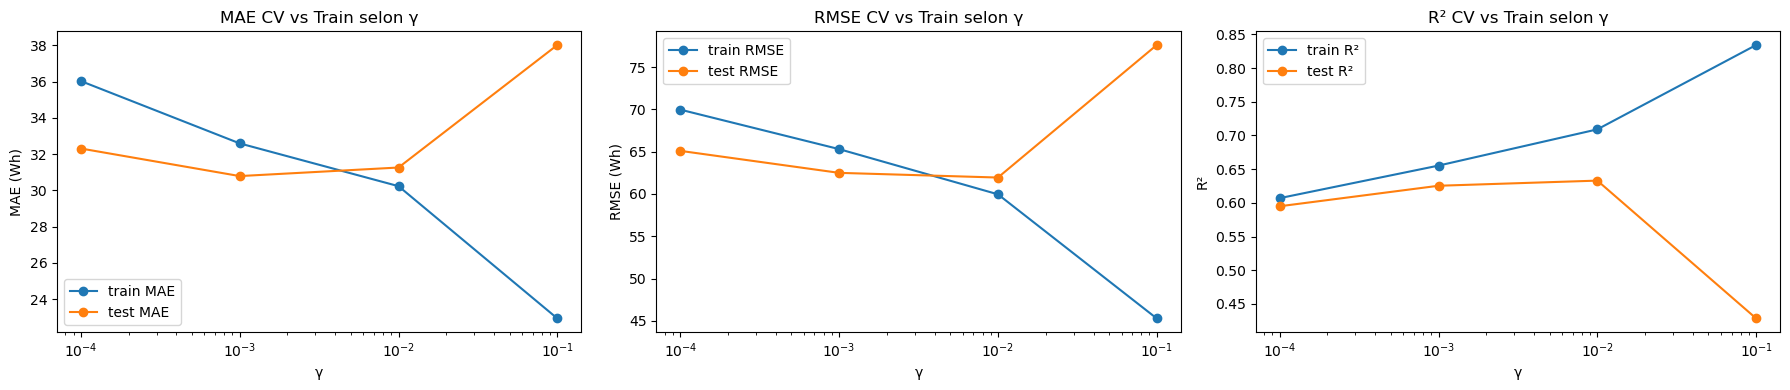

In [ ]:
gammas = np.array(res['param_gamma'], dtype=float)
sigma_y = y_scaler.scale_[0]


mae_train = -res['mean_train_neg_MAE'] * sigma_y
mae_test  = -res['mean_test_neg_MAE']  * sigma_y

mse_train = -res['mean_train_neg_MSE']
mse_test  = -res['mean_test_neg_MSE']
rmse_train = np.sqrt(mse_train) * sigma_y
rmse_test  = np.sqrt(mse_test)  * sigma_y

r2_train = res['mean_train_R2']
r2_test  = res['mean_test_R2']


fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# MAE
axes[0].plot(gammas, mae_train, marker='o', label='train MAE')
axes[0].plot(gammas, mae_test,  marker='o', label='test MAE')
axes[0].set_xscale('log')
axes[0].set_xlabel('γ')
axes[0].set_ylabel('MAE (Wh)')
axes[0].set_title('MAE CV vs Train selon γ')
axes[0].legend()

# RMSE
axes[1].plot(gammas, rmse_train, marker='o', label='train RMSE')
axes[1].plot(gammas, rmse_test,  marker='o', label='test RMSE')
axes[1].set_xscale('log')
axes[1].set_xlabel('γ')
axes[1].set_ylabel('RMSE (Wh)')
axes[1].set_title('RMSE CV vs Train selon γ')
axes[1].legend()

# R²
axes[2].plot(gammas, r2_train, marker='o', label='train R²')
axes[2].plot(gammas, r2_test,  marker='o', label='test R²')
axes[2].set_xscale('log')
axes[2].set_xlabel('γ')
axes[2].set_ylabel('R²')
axes[2].set_title('R² CV vs Train selon γ')
axes[2].legend()

plt.tight_layout()
plt.show()


**Illustration de l’impact de γ (train vs test)**

Les trois graphiques ci-dessus confirment quantitativement l’effet de γ décrit précédemment :

- **γ trop faible (10⁻⁴)**  
  - MAE et RMSE élevées en **train** et en **test**,  
  - MAE et RMSE en **train** plus grandes que celles en **test**,
  - R² faible sur les deux jeux,  
  → influence trop large de chaque point → **sous-apprentissage** (modèle trop rigide).

- **γ intermédiaire (10⁻³ – 10⁻²)**  
  - MAE et RMSE en **test** minimisées,  
  - R² en test maximisé,  
  - **Écart train–test réduit** (petit gap),  
  → bon compromis **biais-variance** : assez de flexibilité pour capter la structure, sans coller au bruit.

- **γ trop élevé (10⁻¹)**  
  - Erreur en **train** extrêmement faible (modèle sur-ajusté),  
  - Erreur en **test** très élevée et R² qui s’effondre,  
  → influence trop locale de chaque point → **sur-apprentissage**.

**Conclusion :**  
Le paramètre γ module la **portée de l’influence** du noyau RBF :  
1. Trop petit → sous-apprendre,  
2. Trop grand → sur-apprendre,  
3. **γ ≃ 10⁻³** → meilleur compromis entre performance moyenne et robustesse sur l’ensemble des folds temporels.  


#### **iv) Régularisation**

On va maintenant tester la **régularisation L2** sur le modèle de régression à noyau.

On va prendre notre meilleur **gamma** (0.001) et faire une validation croisée sur le paramètre de régularisation **alpha**.

In [85]:
alphas = np.logspace(-4, 2, 15)  # de 1e-4 à 1e+2

kr = KernelRidge(kernel='rbf', gamma=1e-3)

grid_alpha = GridSearchCV(
    estimator=kr,
    param_grid={'alpha': alphas},
    cv=tscv,
    scoring=scoring,
    refit='neg_MAE',        
    return_train_score=True,
    n_jobs=-1
)

grid_alpha.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KernelRidge(gamma=0.001, kernel='rbf'), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 2.68269580e-04, 7.19685673e-04, 1.93069773e-03,
       5.17947468e-03, 1.38949549e-02, 3.72759372e-02, 1.00000000e-01,
       2.68269580e-01, 7.19685673e-01, 1.93069773e+00, 5.17947468e+00,
       1.38949549e+01, 3.72759372e+01, 1.00000000e+02])},
             refit='neg_MAE', return_train_score=True,
             scoring={'R2': 'r2', 'neg_MAE': 'neg_mean_absolute_error',
                      'neg_MSE': 'neg_mean_squared_error'})

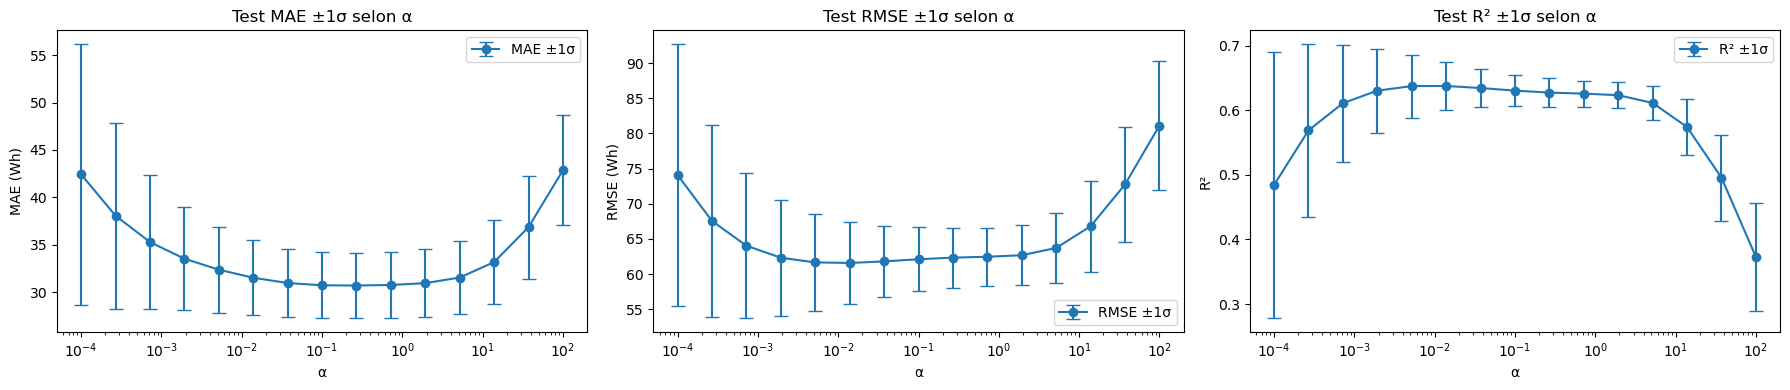

In [ ]:
res = grid_alpha.cv_results_
alphas = np.array(res['param_alpha'], dtype=float)

mae_mean_scaled = -res['mean_test_neg_MAE']
mae_std_scaled  =  res['std_test_neg_MAE']
mse_mean_scaled = -res['mean_test_neg_MSE']
mse_std_scaled  =  res['std_test_neg_MSE']
r2_mean         =  res['mean_test_R2']
r2_std          =  res['std_test_R2']

rmse_mean_scaled = np.sqrt(mse_mean_scaled)
rmse_std_scaled  = mse_std_scaled / (2 * rmse_mean_scaled)

sigma_y = y_scaler.scale_[0]
mae_mean_wh   = mae_mean_scaled  * sigma_y
mae_std_wh    = mae_std_scaled   * sigma_y
rmse_mean_wh  = rmse_mean_scaled * sigma_y
rmse_std_wh   = rmse_std_scaled  * sigma_y

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# MAE
axes[0].errorbar(
    alphas, mae_mean_wh, yerr=mae_std_wh,
    fmt='o-', capsize=5, label='MAE ±1σ'
)
axes[0].set_xscale('log')
axes[0].set_xlabel('α')
axes[0].set_ylabel('MAE (Wh)')
axes[0].set_title('Test MAE ±1σ selon α')
axes[0].legend()

# RMSE
axes[1].errorbar(
    alphas, rmse_mean_wh, yerr=rmse_std_wh,
    fmt='o-', capsize=5, label='RMSE ±1σ'
)
axes[1].set_xscale('log')
axes[1].set_xlabel('α')
axes[1].set_ylabel('RMSE (Wh)')
axes[1].set_title('Test RMSE ±1σ selon α')
axes[1].legend()

# R²
axes[2].errorbar(
    alphas, r2_mean, yerr=r2_std,
    fmt='o-', capsize=5, label='R² ±1σ'
)
axes[2].set_xscale('log')
axes[2].set_xlabel('α')
axes[2].set_ylabel('R²')
axes[2].set_title('Test R² ±1σ selon α')
axes[2].legend()

plt.tight_layout()
plt.show()


On retrouve le même comportement qu'avec le choix de $\gamma$. 

On choisit donc **alpha = 1** car sa **moyenne** en MAE et RMSE fait partie des meilleures et que son **écart-type** est le plus faible surtout en R².

> On va donc choisir **alpha = 1** pour la suite.

L'importance de la régularisation L2 est surtout de **contrôler l'overfitting**.

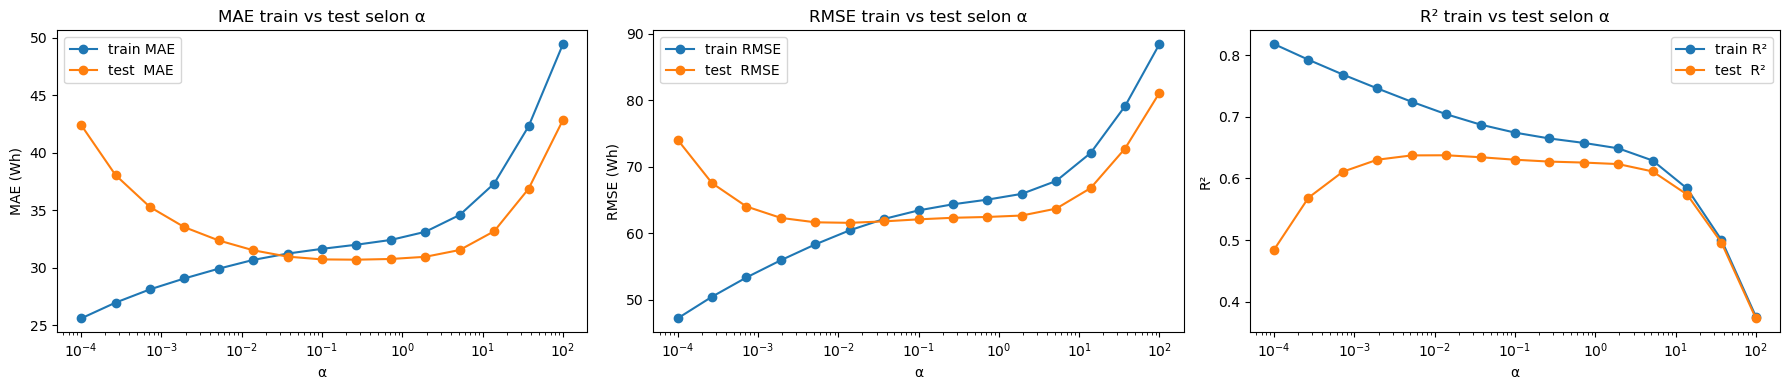

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Récupérer les résultats de la GridSearch sur alpha
res    = grid_alpha.cv_results_
alphas = np.array(res['param_alpha'], dtype=float)
σ_y    = y_scaler.scale_[0]

# 2) Extraire et convertir en échelle originale
#    – MAE
mae_train = -res['mean_train_neg_MAE'] * σ_y
mae_test  = -res['mean_test_neg_MAE']  * σ_y
#    – RMSE (via MSE)
rmse_train = np.sqrt(-res['mean_train_neg_MSE']) * σ_y
rmse_test  = np.sqrt(-res['mean_test_neg_MSE'])  * σ_y
#    – R²
r2_train = res['mean_train_R2']
r2_test  = res['mean_test_R2']

# 3) Tracer train vs test côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18,4))

# MAE
axes[0].plot(alphas, mae_train, marker='o', label='train MAE')
axes[0].plot(alphas, mae_test,  marker='o', label='test  MAE')
axes[0].set_xscale('log')
axes[0].set_title('MAE train vs test selon α')
axes[0].set_xlabel('α'); axes[0].set_ylabel('MAE (Wh)')
axes[0].legend()

# RMSE
axes[1].plot(alphas, rmse_train, marker='o', label='train RMSE')
axes[1].plot(alphas, rmse_test,  marker='o', label='test  RMSE')
axes[1].set_xscale('log')
axes[1].set_title('RMSE train vs test selon α')
axes[1].set_xlabel('α'); axes[1].set_ylabel('RMSE (Wh)')
axes[1].legend()

# R²
axes[2].plot(alphas, r2_train, marker='o', label='train R²')
axes[2].plot(alphas, r2_test,  marker='o', label='test  R²')
axes[2].set_xscale('log')
axes[2].set_title('R² train vs test selon α')
axes[2].set_xlabel('α'); axes[2].set_ylabel('R²')
axes[2].legend()

plt.tight_layout()
plt.show()


On a exactement le même comportement qu'avec $\gamma$ ce qui montre que la **régularisation L2** est très importante pour **éviter l'overfitting**.

En fait, la regularisation L2 est quasiment **obligatoire** pour la régression à noyau.

In [ ]:
from sklearn.model_selection import cross_validate

# 1) Définir les deux estimateurs : sans L2 (alpha=0) vs avec L2 (alpha optimal)
best_gamma = 1e-3
best_alpha = 1 

estimators = {
    'sans_reg' : KernelRidge(kernel='rbf', gamma=best_gamma, alpha=0.0),
    'avec_reg' : KernelRidge(kernel='rbf', gamma=best_gamma, alpha=best_alpha)
}

# 2) Critères à évaluer
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2' : 'r2'
}

# 3) Cross-validation temporelle
results = {}
for name, est in estimators.items():
    cv = cross_validate(
        est, X, y,
        cv=tscv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    # Conversion à l’échelle originale
    sigma_y = y_scaler.scale_[0]
    mae  = -cv['test_MAE']  * sigma_y
    rmse = np.sqrt(-cv['test_MSE']) * sigma_y
    r2   =  cv['test_R2']
    results[name] = {
        'MAE_mean' : mae.mean(),  'MAE_std'  : mae.std(),
        'RMSE_mean': rmse.mean(), 'RMSE_std' : rmse.std(),
        'R2_mean'  : r2.mean(),   'R2_std'   : r2.std()
    }

# 4) Affichage comparatif
for name, metrics in results.items():
    print(f"{name:10s} → "
          f"MAE = {metrics['MAE_mean']:.2f}±{metrics['MAE_std']:.2f} Wh, "
          f"RMSE = {metrics['RMSE_mean']:.2f}±{metrics['RMSE_std']:.2f} Wh, "
          f"R² = {metrics['R2_mean']:.3f}±{metrics['R2_std']:.3f}")


sans_reg   → MAE = 1075.10±337.25 Wh, RMSE = 1825.66±536.37 Wh, R² = -330.710±158.719
avec_reg   → MAE = 30.79±3.51 Wh, RMSE = 62.37±3.96 Wh, R² = 0.625±0.020


- **Sans régularisation**, le modèle explose : MAE/RMSE colossales et R² très négatif → ni la tendance ni la variance ne sont maîtrisées.  
- **Avec L₂** (α ≃ 10⁻²), on obtient à la fois :  
  1. **Une très forte baisse de l’erreur moyenne** 
  2. **Un R² positif et élevé** → le modèle capture correctement la structure sous-jacente,  
  3. **Une faible variance inter-folds** (écarts‐types resserrés).

**Nécessité de la régularisation L₂ en régression à noyaux**

En régression à noyaux, on travaille implicitement dans un **espace de features infini** :  
- chaque point d’entraînement définit une fonction gaussienne,  
- la capacité du modèle est quasi illimitée, donc le **surapprentissage est garanti** sans contrainte.

La **régularisation L₂** (terme `α‖w‖²`) est donc **obligatoir** pour :
1. **Pénaliser la norme** des coefficients dans cet espace de Hilbert,  
2. **Limiter la complexité** du modèle,  
3. **Assurer le bon conditionnement** de la matrice $K$ donc la stabilité numérique (inversion)
4. **Réduire l’overfitting** et garantir une **généralisation fiable**.


**Pourquoi pas L1 ?**

En ce qui concerne la régularisation **L1**, elle n'est pas pertinente pour la régression à noyaux.

La regression à noyau n'apprend pas de poids $w$ sur les variables d’entrée, mais des coefficients $\alpha$ dans :

$$
f(x) = \sum_{i=1}^n \alpha_i\,K(x_i, x)
$$

Donc, dans un modèle à noyau **il n’y a pas de vecteur $w$** dans l’espace d’origine.  
Appliquer $\|\boldsymbol{\alpha}\|_1$ n’a **pas d’interprétation claire** pour contrôler la complexité de $f$ dans l’espace RKHS et n'a pas d’effet sur la **sparsité** des coefficients originels $\boldsymbol{w}$.

Par contre, on peut tester la **regression à noyau** sur le feature set **créé par le lasso** pour voir si il y a un gain de performance.

Le modèle **Lasso** avait supprimé pas mal de variables, on va donc voir si le modèle à noyau fait mieux sur ce **feature set** dans la partie suivante.





#### **v) Comparaison des performances avec la baseline**

On va maintenant rapidement regarder les performances de la **regression à noyau** et les **comparer** aux modèles linéaires (notre baseline).

Pour cela, on va afficher les performances (MAE, RMSE, R²) sur le tous les **features-sets**.

In [98]:
best_alpha_ridge = 0.1      
best_alpha_lasso = 0.01     
best_gamma_kr = 1e-3
best_alpha_kr = 1.0

# Instanciation des modèles
models = {
    'OLS' : LinearRegression(),
    'KernelRidge' : KernelRidge(kernel='rbf', gamma=best_gamma_kr, alpha=best_alpha_kr)
}


# Comparaison des performances sur tous les features-sets
all_results = []
for fs in feature_sets.keys():
    for name, model in models.items():
        if fs == 'FS3_log':
            target = 'log'
        else:
            target = 'raw'
        res = run_model(model, fs=fs, target=target, X_scaled=True, y_scaled=False)
        all_results.append({
            'Feature set': fs,
            'Model': name,
            'Test RMSE': res['test_RMSE'],
            'Test MAE' : res['test_MAE'],
            'Test R²'  : res['test_R2']
        })

perf_all_df = pd.DataFrame(all_results).set_index(['Feature set', 'Model'])
display(perf_all_df)


Test RMSE   Test MAE   Test R²
Feature set Model                                      
FS0         OLS          86.097191  51.756496  0.095048
            KernelRidge  85.057765  49.757239  0.116766
FS1         OLS          85.795362  52.095894  0.101381
            KernelRidge  85.045975  49.737697  0.117011
FS2         OLS          88.679163  55.479304  0.039956
            KernelRidge  89.405562  56.990264  0.024164
FS3         OLS          56.100527  26.811540  0.615778
            KernelRidge  55.853479  26.536570  0.619155
FS3_log     OLS          58.365506  23.962116  0.584127
            KernelRidge  61.683087  24.622964  0.535506

Pour tous les features-sets (sauf `FS3_log`), la régression à noyau fait mieux que l'OLS classique.

> Mais ces gains ne sont clairement pas énormes. Ce qui pose question sur l'intérêt de la régression à noyau par rapport à l'OLS classique. 

On va maintenant tester la regression à noyau sur les variables du **Lasso** pour voir si ca peut être un équivalent à la régularisation L1 sur la regression à noyau.

On avait les colonnes suivantes :
Voici la liste des variables sélectionnées par le Lasso :
- `lag_1`
- `roll_std_6`
- `roll_mean_12`
- `lag_6`
- `roll_mean_6`
- `lights`
- `T6`
- `PC_hum1`
- `lag_12`
- `PC_temp2`
- `Press_mm_hg`
- `RH_out`

Regardons si la regression à noyau sur **les variables du Lasso** fait mieux que la regression à noyau sur le **feature set 3**.

In [103]:
# Évaluer KernelRidge sur FS3 et sur les features sélectionnées
kr = KernelRidge(kernel='rbf', gamma=1e-3, alpha=1.0)

# 1) Full FS3
res_fs3 = run_model(
    model=kr,
    fs='FS3',
    target='raw',
    X_scaled=True,
    y_scaled=False
)

# 2) Selected features
feature_sets['FS_selected'] = [
    'lag_1', 'roll_std_6', 'roll_mean_12', 'lag_6', 'roll_mean_6',
    'lights', 'T6', 'PC_hum1', 'lag_12', 'PC_temp2', 'Press_mm_hg', 'RH_out'
]
res_sel = run_model(
    model=kr,
    fs='FS_selected',
    target='raw',
    X_scaled=True,
    y_scaled=False
)

df_compare = pd.DataFrame([
    {
        'Feature set': 'FS3',
        'Test RMSE': res_fs3['test_RMSE'],
        'Test MAE' : res_fs3['test_MAE'],
        'Test R²'  : res_fs3['test_R2']
    },
    {
        'Feature set': 'FS_selected',
        'Test RMSE': res_sel['test_RMSE'],
        'Test MAE' : res_sel['test_MAE'],
        'Test R²'  : res_sel['test_R2']
    }
]).set_index('Feature set')

display(df_compare)

,Test RMSE,Test MAE,Test R²
Feature set,,,
FS3,55.853479,26.536570,0.619155
FS_selected,55.860883,26.345004,0.619054


Les performances sont équivalente (avec un très léger gain en **MAE**). 

C'est très intéressent car ca montre qu'on peut utiliser la régularisation **L1** dans le cadre de la régression à noyau.

C'est une forme détournée certes puisqu'on fait d'abord le lasso puis on applique la regression à noyau sur les variables sélectionnées, mais c'est une bonne alternative à la régression à noyau classique.

> Nous ne sommes pas certains que cette approche soit optimale ou généralisable, mais elle ouvre une piste intéressante pour combiner sélection de variables (L1) et modélisation à noyaux. 

*(c'est peut être déjà connue... ?)*

**Conclusion de la partie 6.2 – Régression à noyau**

La régression à noyau RBF, correctement normalisée et régularisée (γ≈10⁻³, α≈1), offre des gains (bien que légers) par rapport à l’OLS sur nos jeux **features-sets**.  
**Cependant**, la construction et l'inversion de la matrice $K$ se fait respectivement en $O(n^2)$ et $O(n^3)$ pour $n\approx20\,000$. Sans compter la validation croisée ×5, et stockage mémoire $O(n^2)$.

En pratique, la régression linéaire (OLS) s’entraîne en quelques secondes, consomme peu de mémoire, reste tout aussi performante (RMSE ≈ 56 Wh, R² ≈ 0.61) et offre une interprétabilité directe.  

Pour toutes ces raisons, la régression linéaire est à privilégier dans notre cas. 

> **À suivre** :  
> Réseau de neuronnes dense (MLP) pour capturer la non-linéarité sans les inconvénients de la régression à noyau.